## 42577 Introduction to Business Analytics Project

Barbara Anna Koska s233500

Giulia Andreatta s233128

Gianmarco Massari s240111

Ignacio Ripoll Gonzalez s242875

# **Data Selection and Assumptions**

For this analysis, we have chosen to focus on data from **01/01/2016 00:00:00 to 31/01/2019 23:59:59**, despite the dataset spanning from 2012 to 2021. This decision is based on two critical observations:  

1. **Inconsistent Data Frequency Post-2020**: Starting in 2020, data entries exhibit irregular recording patterns. This inconsistency is not indicative of actual EV usage but is likely due to a recording error, making data beyond 2019 unreliable for analysis.  
2. **Limited EV Adoption Pre-2016**: Prior to 2016, the usage of EVs and charging stations was relatively low, reflected in fewer recorded data points. This shift aligns with the **launch of the Tesla Model X in September 2015**, which significantly accelerated EV adoption and utilization rates.  

This temporal scope will be applied to **clustering, prediction, and exploratory analysis** to derive meaningful insights into EV charging patterns.

# **Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, accuracy_score, r2_score, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import kpss, adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import folium
from google.colab import drive
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.fft import fft
import warnings
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

In [ ]:
# Set Seaborn Style For Better Aesthetics
sns.set_theme(style='whitegrid')
%matplotlib inline

# **Data Loading**

In [ ]:
# Data Loading for Drive
drive.mount('/content/drive')
FILE_PATH = '/content/drive/My Drive/EVChargingStationUsage.csv'

Mounted at /content/drive


In [ ]:
# Data Loading Constants

#FILE_PATH = 'EVChargingStationUsage.csv'  # Path to the dataset

In [ ]:
# Data Loading Function
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    print("\nDataset loaded successfully.")
    return df

# Execute Data Loading
df = load_dataset(FILE_PATH)

df.head()

<ipython-input-6-ce49ab42ae21>:3: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



Dataset loaded successfully.


Station Name          MAC Address           Org Name  \
0  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
1  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
2  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
3  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
4  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   

        Start Date Start Time Zone         End Date End Time Zone  \
0  7/29/2011 20:17             PDT  7/29/2011 23:20           PDT   
1   7/30/2011 0:00             PDT   7/30/2011 0:02           PDT   
2   7/30/2011 8:16             PDT  7/30/2011 12:34           PDT   
3  7/30/2011 14:51             PDT  7/30/2011 16:55           PDT   
4  7/30/2011 18:51             PDT  7/30/2011 20:03           PDT   

  Transaction Date (Pacific Time) Total Duration (hh:mm:ss)  \
0                 7/29/2011 23:20                   3:03:32   
1                  7/30/2011 0:02                   0:02:06   
2                 7/30/2011 12:34                   4:17:32   
3                 7/30/2011 16:55                   2:03:24   
4                 7/30/2011 20:03                   1:11:24   

  Charging Time (hh:mm:ss)  ...   Longitude  Currency  Fee  \
0                  1:54:03  ... -122.160309       USD  0.0   
1                  0:01:54  ... -122.160309       USD  0.0   
2                  4:17:28  ... -122.160309       USD  0.0   
3                  2:02:58  ... -122.160309       USD  0.0   
4                  0:43:54  ... -122.160309       USD  0.0   

              Ended By  Plug In Event Id Driver Postal Code  User ID County  \
0  Plug Out at Vehicle                 3            95124.0   3284.0    NaN   
1             Customer                 4            94301.0   4169.0    NaN   
2  Plug Out at Vehicle                 5            94301.0   4169.0    NaN   
3             Customer                 6            94302.0   2545.0    NaN   
4  Plug Out at Vehicle                 7            94043.0   3765.0    NaN   

  System S/N Model Number  
0        NaN          NaN  
1        NaN          NaN  
2        NaN          NaN  
3        NaN          NaN  
4        NaN          NaN  

[5 rows x 33 columns]

# **Data Cleaning**

In [ ]:
def list_attributes_with_types(df):
    print("\n--- List of Attributes and Types ---")
    for i, (attribute, dtype) in enumerate(df.dtypes.items(), start=1):
        print(f"{i}. {attribute}: {dtype}")

# Execute the function
list_attributes_with_types(df)


--- List of Attributes and Types ---
1. Station Name: object
2. MAC Address: object
3. Org Name: object
4. Start Date: object
5. Start Time Zone: object
6. End Date: object
7. End Time Zone: object
8. Transaction Date (Pacific Time): object
9. Total Duration (hh:mm:ss): object
10. Charging Time (hh:mm:ss): object
11. Energy (kWh): float64
12. GHG Savings (kg): float64
13. Gasoline Savings (gallons): float64
14. Port Type: object
15. Port Number: int64
16. Plug Type: object
17. EVSE ID: float64
18. Address 1: object
19. City: object
20. State/Province: object
21. Postal Code: int64
22. Country: object
23. Latitude: float64
24. Longitude: float64
25. Currency: object
26. Fee: float64
27. Ended By: object
28. Plug In Event Id: int64
29. Driver Postal Code: float64
30. User ID: object
31. County: object
32. System S/N: float64
33. Model Number: object


In [ ]:
def get_unique_values_and_counts(df, attributes=None):
    # Get all object-type attributes if no specific attributes are provided
    if attributes is None:
        attributes = df.columns.tolist()

    print("\n--- Unique Values and Counts for Specified Attributes ---")
    for attr in attributes:
        if attr in df.columns:
            unique_count = df[attr].nunique()  # Number of unique values
            print(f"\nAttribute: {attr} (Unique Values: {unique_count})")
            value_counts = df[attr].value_counts()
            print(value_counts)
        else:
            print(f"\nWarning: Attribute '{attr}' not found in the dataset.")

get_unique_values_and_counts(df)


--- Unique Values and Counts for Specified Attributes ---

Attribute: Station Name (Unique Values: 47)
Station Name
PALO ALTO CA / HAMILTON #2        23721
PALO ALTO CA / HAMILTON #1        14888
PALO ALTO CA / WEBSTER #1         14432
PALO ALTO CA / BRYANT #2          14389
PALO ALTO CA / HIGH #4            13898
PALO ALTO CA / BRYANT #1          13436
PALO ALTO CA / WEBSTER #2         12669
PALO ALTO CA / CAMBRIDGE #1       11163
PALO ALTO CA / HIGH #1            10756
PALO ALTO CA / WEBSTER #3         10484
PALO ALTO CA / TED THOMPSON #1     9814
PALO ALTO CA / CAMBRIDGE #2        9256
PALO ALTO CA / MPL #6              8996
PALO ALTO CA / HIGH #3             8317
PALO ALTO CA / MPL #4              7787
PALO ALTO CA / MPL #5              7544
PALO ALTO CA / HIGH #2             6930
PALO ALTO CA / RINCONADA LIB 3     6499
PALO ALTO CA / RINCONADA LIB 1     6212
PALO ALTO CA / BRYANT #6           5857
PALO ALTO CA / RINCONADA LIB 2     5553
PALO ALTO CA / BRYANT #5           5332
PAL

In [ ]:
def filter_currency(df):
    initial_shape = df.shape
    # Keep only rows with 'Currency' equal to 'USD'
    df = df[df['Currency'] == 'USD']
    filtered_shape = df.shape

    # Print summary of the filtering
    print(f"Filtered rows based on 'Currency': {initial_shape[0] - filtered_shape[0]} rows dropped.")
    return df

# Apply the function
df = filter_currency(df)

Filtered rows based on 'Currency': 1802 rows dropped.


In [ ]:
def drop_mismatched_time_zones(df):
    initial_shape = df.shape
    # Keep only rows where 'Start Time Zone' matches 'End Time Zone'
    df = df[df['Start Time Zone'] == df['End Time Zone']]
    filtered_shape = df.shape

    # Print summary of the filtering
    print(f"Dropped rows with mismatched time zones: {initial_shape[0] - filtered_shape[0]} rows dropped.")
    return df

# Apply the function
df = drop_mismatched_time_zones(df)

Dropped rows with mismatched time zones: 119 rows dropped.


This function removes unnecessary columns from the dataset based on a predefined dictionary (COLUMNS_TO_DROP) to simplify the dataset by removing irrelevant or redundant columns, which reduces noise and focuses on the meaningful data for analysis.

In [ ]:
COLUMNS_TO_DROP = {
    'Station Name': 0,
    'MAC Address': 1,
    'Org Name': 1,
    'Start Date': 0,
    'Start Time Zone': 0,
    'End Date': 0,
    'End Time Zone': 1,
    'Transaction Date (Pacific Time)': 0,
    'Total Duration (hh:mm:ss)': 0,
    'Charging Time (hh:mm:ss)': 0,
    'Energy (kWh)': 0,
    'GHG Savings (kg)': 0,
    'Gasoline Savings (gallons)': 0,
    'Port Type': 0,
    'Port Number': 0,
    'Plug Type': 0,
    'EVSE ID': 1,
    'Address 1': 1,
    'City': 1,
    'State/Province': 1,
    'Postal Code': 0,
    'Country': 1,
    'Latitude': 0,
    'Longitude': 0,
    'Currency': 1,
    'Fee': 0,
    'Ended By': 0,
    'Plug In Event Id': 1,
    'Driver Postal Code': 1,
    'User ID': 0,
    'County': 0,
    'System S/N': 1,
    'Model Number': 0
}

def drop_unnecessary_columns(df, columns_to_drop_dict):
    # Filter columns marked as '1' for dropping
    columns_to_drop = [col for col, drop in columns_to_drop_dict.items() if drop == 1]

    # Drop the specified columns
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"Dropped columns: {', '.join(columns_to_drop)}")
    return df

# Apply the function
df = drop_unnecessary_columns(df, COLUMNS_TO_DROP)

Dropped columns: MAC Address, Org Name, End Time Zone, EVSE ID, Address 1, City, State/Province, Country, Currency, Plug In Event Id, Driver Postal Code, System S/N


<ipython-input-11-d317a933690e>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=columns_to_drop, inplace=True)


In [ ]:
def convert_to_object(df, columns):
    for column in columns:
        if column in df.columns:
            df[column] = df[column].astype('object')
    return df


def convert_to_datetime(df, columns):
    initial_shape = df.shape

    for column in columns:
        if column in df.columns:
            df[column] = pd.to_datetime(df[column], errors='coerce')

    # Drop rows with invalid datetime values in specified columns
    df = df.dropna(subset=columns)
    dropped_rows = initial_shape[0] - df.shape[0]

    print(f"\nDropped {dropped_rows} rows with invalid datetime values in {columns}.")
    for column in columns:
        print(f"Remaining invalid values in '{column}': {df[column].isnull().sum()}")

    return df


def convert_to_float(df, columns):
    for column in columns:
        if column in df.columns:
            initial_missing = df[column].isnull().sum()
            df.loc[:, column] = pd.to_numeric(df[column], errors='coerce')
            final_missing = df[column].isnull().sum()
            print(f"'{column}': {final_missing - initial_missing} invalid values converted to NaN.")

    return df


# Define the desired conversions
object_columns = [
    'Station Name',
    'Start Time Zone',
    'End Time Zone',
    'Port Type',
    'Port Number',
    'Plug Type',
    'Postal Code',
    'Ended By',
    'Plug In Event Id',
    'User ID', 'County',
    'Model Number'
]

datetime_columns = [
    'Start Date',
    'End Date'
]

float_columns = [
    'Energy (kWh)',
    'GHG Savings (kg)',
    'Gasoline Savings (gallons)',
    'Latitude',
    'Longitude',
    'Fee'
]

# Apply conversions
df = convert_to_object(df, object_columns)
df = convert_to_datetime(df, datetime_columns)
df = convert_to_float(df, float_columns)

# Verify data types
print("\n--- Data Types After Conversion ---")
print(df.dtypes)


Dropped 40 rows with invalid datetime values in ['Start Date', 'End Date'].
Remaining invalid values in 'Start Date': 0
Remaining invalid values in 'End Date': 0
'Energy (kWh)': 0 invalid values converted to NaN.
'GHG Savings (kg)': 0 invalid values converted to NaN.
'Gasoline Savings (gallons)': 0 invalid values converted to NaN.
'Latitude': 0 invalid values converted to NaN.
'Longitude': 0 invalid values converted to NaN.
'Fee': 0 invalid values converted to NaN.

--- Data Types After Conversion ---
Station Name                               object
Start Date                         datetime64[ns]
Start Time Zone                            object
End Date                           datetime64[ns]
Transaction Date (Pacific Time)            object
Total Duration (hh:mm:ss)                  object
Charging Time (hh:mm:ss)                   object
Energy (kWh)                              float64
GHG Savings (kg)                          float64
Gasoline Savings (gallons)                

In [ ]:
# Remove Duplicates

def remove_duplicates(df):
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"\n--- Removing Duplicates ---")
        df = df.drop_duplicates()
        print(f"Removed {duplicates} duplicate rows.")
    else:
        print("\nNo duplicate rows found.")
    return df

# Execute duplicate removal
df = remove_duplicates(df)


--- Removing Duplicates ---
Removed 4 duplicate rows.


In [ ]:
# Inspect Dataset Structure
def inspect_dataset(df):
    print("\n--- Dataset Information ---")
    df.info()

    print("\n--- Summary Statistics ---")
    print(df.describe(include='all'))

    print("\n--- Checking for Missing Values ---")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

# Execute dataset inspection
inspect_dataset(df)


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
Index: 257450 entries, 0 to 259414
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Station Name                     257450 non-null  object        
 1   Start Date                       257450 non-null  datetime64[ns]
 2   Start Time Zone                  257450 non-null  object        
 3   End Date                         257450 non-null  datetime64[ns]
 4   Transaction Date (Pacific Time)  257358 non-null  object        
 5   Total Duration (hh:mm:ss)        257450 non-null  object        
 6   Charging Time (hh:mm:ss)         257450 non-null  object        
 7   Energy (kWh)                     257450 non-null  float64       
 8   GHG Savings (kg)                 257450 non-null  float64       
 9   Gasoline Savings (gallons)       257450 non-null  float64       
 10  Port Type           

In [ ]:
# Drop Rows with High Percentage of Missing Values
def drop_rows_with_missing_values(df, threshold=0.3):
    # Calculate the maximum number of missing values allowed
    max_missing = int(threshold * df.shape[1])

    # Identify rows with too many missing values
    rows_before = df.shape[0]
    df_cleaned = df[df.isnull().sum(axis=1) <= max_missing]
    rows_after = df_cleaned.shape[0]

    print(f"\nDropped {rows_before - rows_after} rows with more than {threshold * 100}% missing values.")
    return df_cleaned

# Execute the function to drop rows
df = drop_rows_with_missing_values(df, threshold=0.3)


Dropped 0 rows with more than 30.0% missing values.


In [ ]:
def fill_missing_values(df):
    changes_summary = []

    # Impute Port Type with mode
    if 'Port Type' in df.columns:
        missing_before = df['Port Type'].isnull().sum()
        mode_value = df['Port Type'].mode()[0]
        df['Port Type'] = df['Port Type'].fillna(mode_value)
        changes_summary.append(f"Filled {missing_before} missing values in 'Port Type' with mode ({mode_value}).")

    # Impute Ended By with mode
    if 'Ended By' in df.columns:
        missing_before = df['Ended By'].isnull().sum()
        mode_value = df['Ended By'].mode()[0]
        df['Ended By'] = df['Ended By'].fillna(mode_value)
        changes_summary.append(f"Filled {missing_before} missing values in 'Ended By' with mode ({mode_value}).")

    # Impute User ID with mode
    if 'User ID' in df.columns:
        missing_before = df['User ID'].isnull().sum()
        mode_value = df['User ID'].mode()[0]
        df['User ID'] = df['User ID'].fillna(mode_value)
        changes_summary.append(f"Filled {missing_before} missing values in 'User ID' with mode ({mode_value}).")

    # Impute County with 'Unknown'
    if 'County' in df.columns:
        missing_before = df['County'].isnull().sum()
        df['County'] = df['County'].fillna('Unknown')
        changes_summary.append(f"Filled {missing_before} missing values in 'County' with 'Unknown'.")

    # Impute Model Number with 'Unknown'
    if 'Model Number' in df.columns:
        missing_before = df['Model Number'].isnull().sum()
        df['Model Number'] = df['Model Number'].fillna('Unknown')
        changes_summary.append(f"Filled {missing_before} missing values in 'Model Number' with 'Unknown'.")

    # Print summary of changes
    print("\n--- Missing Values Handling Summary ---")
    for change in changes_summary:
        print(change)

    return df

# Apply the function
df = fill_missing_values(df)


--- Missing Values Handling Summary ---
Filled 1 missing values in 'Port Type' with mode (Level 2).
Filled 135 missing values in 'Ended By' with mode (Plug Out at Vehicle).
Filled 7502 missing values in 'User ID' with mode (283441).
Filled 82916 missing values in 'County' with 'Unknown'.
Filled 77202 missing values in 'Model Number' with 'Unknown'.


In [ ]:
def remove_outliers_iqr(df, columns):
    initial_shape = df.shape
    bounds = {}

    # Calculate IQR bounds for each column
    for column in columns:
        if column in df.columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = 0  # Set lower bound explicitly to 0 for attributes like time
            upper_bound = Q3 + 1.5 * IQR
            bounds[column] = (lower_bound, upper_bound)
            print(f"'{column}': Calculated bounds [{lower_bound}, {upper_bound}]")

    # Identify rows to keep
    mask = pd.Series(True, index=df.index)
    for column, (lower_bound, upper_bound) in bounds.items():
        mask &= (df[column] >= lower_bound) & (df[column] <= upper_bound)
        lower_outliers = (df[column] < lower_bound).sum()
        upper_outliers = (df[column] > upper_bound).sum()
        print(f"'{column}': {lower_outliers} lower-bound outliers (< {lower_bound})")
        print(f"'{column}': {upper_outliers} upper-bound outliers (> {upper_bound})")

    # Apply the mask to filter the dataset
    df = df[mask]

    # Report total rows removed
    print(f"\nTotal rows removed: {initial_shape[0] - df.shape[0]} out of {initial_shape[0]}.")

    return df

# Attributes to check for outliers
attributes_to_check = [
    'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Fee'
]

# Apply the function
df = remove_outliers_iqr(df, attributes_to_check)

'Energy (kWh)': Calculated bounds [0, 22.98760575]
'GHG Savings (kg)': Calculated bounds [0, 9.656]
'Gasoline Savings (gallons)': Calculated bounds [0, 2.8845]
'Fee': Calculated bounds [0, 4.125]
'Energy (kWh)': 0 lower-bound outliers (< 0)
'Energy (kWh)': 8642 upper-bound outliers (> 22.98760575)
'GHG Savings (kg)': 0 lower-bound outliers (< 0)
'GHG Savings (kg)': 8638 upper-bound outliers (> 9.656)
'Gasoline Savings (gallons)': 0 lower-bound outliers (< 0)
'Gasoline Savings (gallons)': 8644 upper-bound outliers (> 2.8845)
'Fee': 0 lower-bound outliers (< 0)
'Fee': 14142 upper-bound outliers (> 4.125)

Total rows removed: 17352 out of 257450.


In [ ]:
# Execute Inspection
inspect_dataset(df)


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
Index: 240098 entries, 0 to 259414
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Station Name                     240098 non-null  object        
 1   Start Date                       240098 non-null  datetime64[ns]
 2   Start Time Zone                  240098 non-null  object        
 3   End Date                         240098 non-null  datetime64[ns]
 4   Transaction Date (Pacific Time)  240014 non-null  object        
 5   Total Duration (hh:mm:ss)        240098 non-null  object        
 6   Charging Time (hh:mm:ss)         240098 non-null  object        
 7   Energy (kWh)                     240098 non-null  float64       
 8   GHG Savings (kg)                 240098 non-null  float64       
 9   Gasoline Savings (gallons)       240098 non-null  float64       
 10  Port Type           

In [ ]:
def add_calculated_columns(df):
    # Helper Function: Convert time columns to seconds
    def convert_time_to_seconds(column):
        return column.apply(lambda x:
            sum(float(unit) * factor for unit, factor in zip(str(x).split(':'), [3600, 60, 1]))
            if pd.notnull(x) else None
        )
    # Convert time columns to seconds
    df['Total Duration (ss)'] = convert_time_to_seconds(df['Total Duration (hh:mm:ss)']).astype(float)
    df['Charging Time (ss)'] = convert_time_to_seconds(df['Charging Time (hh:mm:ss)']).astype(float)

    # 1. Temporal Features
    df['Day'] = df['Start Date'].dt.day
    df['Month'] = df['Start Date'].dt.month_name()
    df['Year'] = df['Start Date'].dt.year
    df['Day of the Week'] = df['Start Date'].dt.day_name()
    df['Hour of the Day'] = df['Start Date'].dt.hour
    df['Time of Day'] = pd.cut(
        df['Hour of the Day'],
        bins=[0, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening'],
        right=False
    )
    df['Weekend'] = df['Day of the Week'].isin(['Saturday', 'Sunday'])

    # 2. Usage Metrics
    df['Idle Time (seconds)'] = df['Total Duration (ss)'] - df['Charging Time (ss)']
    df['Charging Efficiency (kWh/sec)'] = df['Energy (kWh)'] / df['Charging Time (ss)']
    df['Cost per kWh'] = df['Fee'] / df['Energy (kWh)']
    df['Cost per Minute'] = df['Fee'] / df['Charging Time (ss)']

    # 3. Environmental Impact
    df['GHG Savings Rate'] = df['GHG Savings (kg)'] / df['Energy (kWh)']
    df['Gasoline Savings per kWh'] = df['Gasoline Savings (gallons)'] / df['Energy (kWh)']

    # 5. Duration-Based Features
    df['Session Length'] = pd.cut(
        df['Total Duration (ss)'],
        bins=[0, 30*60, 2*60*60, float('inf')],  # 0-30min, 30-120min, >120min
        labels=['Short', 'Medium', 'Long']
    )

    return df

add_calculated_columns(df)

Station Name          Start Date Start Time Zone  \
0           PALO ALTO CA / HAMILTON #1 2011-07-29 20:17:00             PDT   
1           PALO ALTO CA / HAMILTON #1 2011-07-30 00:00:00             PDT   
2           PALO ALTO CA / HAMILTON #1 2011-07-30 08:16:00             PDT   
3           PALO ALTO CA / HAMILTON #1 2011-07-30 14:51:00             PDT   
4           PALO ALTO CA / HAMILTON #1 2011-07-30 18:51:00             PDT   
...                                ...                 ...             ...   
259407        PALO ALTO CA / BRYANT #6 2020-12-31 14:51:00             PST   
259409     PALO ALTO CA / CAMBRIDGE #5 2020-12-31 15:51:00             PST   
259410  PALO ALTO CA / TED THOMPSON #3 2020-12-31 16:39:00             PST   
259413       PALO ALTO CA / WEBSTER #1 2020-12-31 17:49:00             PST   
259414     PALO ALTO CA / CAMBRIDGE #4 2020-12-31 18:19:00             PST   

                  End Date Transaction Date (Pacific Time)  \
0      2011-07-29 23:20:00                 7/29/2011 23:20   
1      2011-07-30 00:02:00                  7/30/2011 0:02   
2      2011-07-30 12:34:00                 7/30/2011 12:34   
3      2011-07-30 16:55:00                 7/30/2011 16:55   
4      2011-07-30 20:03:00                 7/30/2011 20:03   
...                    ...                             ...   
259407 2021-01-04 21:01:00                  1/4/2021 21:03   
259409 2020-12-31 17:30:00                12/31/2020 17:31   
259410 2020-12-31 17:14:00                12/31/2020 17:16   
259413 2020-12-31 21:55:00                12/31/2020 21:56   
259414 2020-12-31 19:01:00                12/31/2020 19:02   

       Total Duration (hh:mm:ss) Charging Time (hh:mm:ss)  Energy (kWh)  \
0                        3:03:32                  1:54:03      6.249457   
1                        0:02:06                  0:01:54      0.106588   
2                        4:17:32                  4:17:28     14.951777   
3                        2:03:24                  2:02:58      7.159643   
4                        1:11:24                  0:43:54      1.957765   
...                          ...                      ...           ...   
259407                   6:10:05                  1:51:46     11.493000   
259409                   1:38:27                  1:21:36      2.535000   
259410                   0:35:44                  0:35:18      1.841000   
259413                   4:05:34                  3:53:42     11.976000   
259414                   0:42:07                  0:41:44      1.571000   

        GHG Savings (kg)  Gasoline Savings (gallons)  ... Hour of the Day  \
0                  2.625                       0.784  ...              20   
1                  0.045                       0.013  ...               0   
2                  6.280                       1.876  ...               8   
3                  3.007                       0.899  ...              14   
4                  0.822                       0.246  ...              18   
...                  ...                         ...  ...             ...   
259407             4.827                       1.442  ...              14   
259409             1.065                       0.318  ...              15   
259410             0.773                       0.231  ...              16   
259413             5.030                       1.503  ...              17   
259414             0.660                       0.197  ...              18   

       Time of Day Weekend Idle Time (seconds)  Charging Efficiency (kWh/sec)  \
0          Evening   False              4169.0                       0.000913   
1            Night    True                12.0                       0.000935   
2          Morning    True                 4.0                       0.000968   
3        Afternoon    True                26.0                       0.000970   
4          Evening    True              1650.0                       0.000743   
...            ...     ...      

In [ ]:
# Attributes to check for outliers
attributes_to_check = [
    'Total Duration (ss)','Charging Time (ss)'
]

# Outliers function
df = remove_outliers_iqr(df, attributes_to_check)

'Total Duration (ss)': Calculated bounds [0, 20102.0]
'Charging Time (ss)': Calculated bounds [0, 17101.5]
'Total Duration (ss)': 0 lower-bound outliers (< 0)
'Total Duration (ss)': 8119 upper-bound outliers (> 20102.0)
'Charging Time (ss)': 0 lower-bound outliers (< 0)
'Charging Time (ss)': 2420 upper-bound outliers (> 17101.5)

Total rows removed: 9173 out of 240098.


In [ ]:
def drop_invalid_duration_rows(df):
    # Initial shape of the dataset
    initial_shape = df.shape

    # Filter invalid rows
    invalid_rows = df[df['Total Duration (ss)'] < df['Charging Time (ss)']].shape[0]
    df = df[df['Total Duration (ss)'] >= df['Charging Time (ss)']]

    # Report results
    print(f"\nDropped {invalid_rows} rows where 'Total Duration' was less than 'Charging Time'.")
    print(f"Total rows removed: {initial_shape[0] - df.shape[0]} out of {initial_shape[0]}.")

    return df

# Apply the function
df = drop_invalid_duration_rows(df)


Dropped 26 rows where 'Total Duration' was less than 'Charging Time'.
Total rows removed: 26 out of 230925.


In [ ]:
# Count column
df['Count'] = df.groupby(pd.Grouper(key='Start Date', freq='D'))['Start Date'].transform('count')

In [ ]:
# Execute Inspection
inspect_dataset(df)


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
Index: 230899 entries, 0 to 259414
Data columns (total 38 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Station Name                     230899 non-null  object        
 1   Start Date                       230899 non-null  datetime64[ns]
 2   Start Time Zone                  230899 non-null  object        
 3   End Date                         230899 non-null  datetime64[ns]
 4   Transaction Date (Pacific Time)  230816 non-null  object        
 5   Total Duration (hh:mm:ss)        230899 non-null  object        
 6   Charging Time (hh:mm:ss)         230899 non-null  object        
 7   Energy (kWh)                     230899 non-null  float64       
 8   GHG Savings (kg)                 230899 non-null  float64       
 9   Gasoline Savings (gallons)       230899 non-null  float64       
 10  Port Type           

# **Data analysis Visualisation**

In [ ]:
df.head()

Station Name          Start Date Start Time Zone  \
0  PALO ALTO CA / HAMILTON #1 2011-07-29 20:17:00             PDT   
1  PALO ALTO CA / HAMILTON #1 2011-07-30 00:00:00             PDT   
2  PALO ALTO CA / HAMILTON #1 2011-07-30 08:16:00             PDT   
3  PALO ALTO CA / HAMILTON #1 2011-07-30 14:51:00             PDT   
4  PALO ALTO CA / HAMILTON #1 2011-07-30 18:51:00             PDT   

             End Date Transaction Date (Pacific Time)  \
0 2011-07-29 23:20:00                 7/29/2011 23:20   
1 2011-07-30 00:02:00                  7/30/2011 0:02   
2 2011-07-30 12:34:00                 7/30/2011 12:34   
3 2011-07-30 16:55:00                 7/30/2011 16:55   
4 2011-07-30 20:03:00                 7/30/2011 20:03   

  Total Duration (hh:mm:ss) Charging Time (hh:mm:ss)  Energy (kWh)  \
0                   3:03:32                  1:54:03      6.249457   
1                   0:02:06                  0:01:54      0.106588   
2                   4:17:32                  4:17:28     14.951777   
3                   2:03:24                  2:02:58      7.159643   
4                   1:11:24                  0:43:54      1.957765   

   GHG Savings (kg)  Gasoline Savings (gallons)  ... Time of Day Weekend  \
0             2.625                       0.784  ...     Evening   False   
1             0.045                       0.013  ...       Night    True   
2             6.280                       1.876  ...     Morning    True   
3             3.007                       0.899  ...   Afternoon    True   
4             0.822                       0.246  ...     Evening    True   

  Idle Time (seconds) Charging Efficiency (kWh/sec)  Cost per kWh  \
0              4169.0                      0.000913           0.0   
1                12.0                      0.000935           0.0   
2                 4.0                      0.000968           0.0   
3                26.0                      0.000970           0.0   
4              1650.0                      0.000743           0.0   

   Cost per Minute  GHG Savings Rate Gasoline Savings per kWh Session Length  \
0              0.0          0.420036                 0.125451           Long   
1              0.0          0.422186                 0.121965          Short   
2              0.0          0.420017                 0.125470           Long   
3              0.0          0.419993                 0.125565           Long   
4              0.0          0.419867                 0.125653         Medium   

  Count  
0     1  
1     4  
2     4  
3     4  
4     4  

[5 rows x 38 columns]

In [ ]:
# Data Visualization Constants
PLOT_STYLE = 'seaborn-v0_8-whitegrid'  # Style for plots
PLOT_SIZE = (12, 6)  # Default figure size
TITLE_FONT_SIZE = 16  # Font size for plot titles
LABEL_FONT_SIZE = 14  # Font size for axis labels
TICK_FONT_SIZE = 12  # Font size for axis ticks
COLOR_PALETTE = 'pastel6'  # Default color palette
TRANSPARENCY = 0.7  # Transparency for plot elements
SAVE_FIGURES_DIR = './figures'  # Directory to save plots
SAVE_FIGURES = False  # Toggle to save plots
GRID = True  # Display grid on plots
DAY_OF_WEEK_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
MONTH_ORDER = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

In [ ]:
def plot_histogram(df, column, bins=30):
    plt.style.use(PLOT_STYLE)
    plt.figure(figsize=PLOT_SIZE)

    # Plot histogram with light blue color for bars
    sns.histplot(
        data=df,
        x=column,
        bins=bins,
        alpha=TRANSPARENCY,
        color='lightblue',
        stat='density'  # Align histogram density with KDE
    )

    # Overlay KDE with proper alignment
    sns.kdeplot(
        data=df,
        x=column,
        color='darkblue',
        linewidth=2,
        fill=False,  # Disable filling under the curve
        cut=0,       # Avoid extending KDE beyond data range
        common_norm=False  # Ensure KDE matches histogram scaling
    )

    plt.title(f'Histogram of {column}', fontsize=TITLE_FONT_SIZE)
    plt.xlabel(column, fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Density', fontsize=LABEL_FONT_SIZE)
    plt.grid(GRID)
    plt.xticks(fontsize=TICK_FONT_SIZE)
    plt.yticks(fontsize=TICK_FONT_SIZE)

    if SAVE_FIGURES:
        plt.savefig(f"{SAVE_FIGURES_DIR}/histogram_{column}.png")

    plt.show()


--- Plotting Histogram for Total Duration (ss) ---


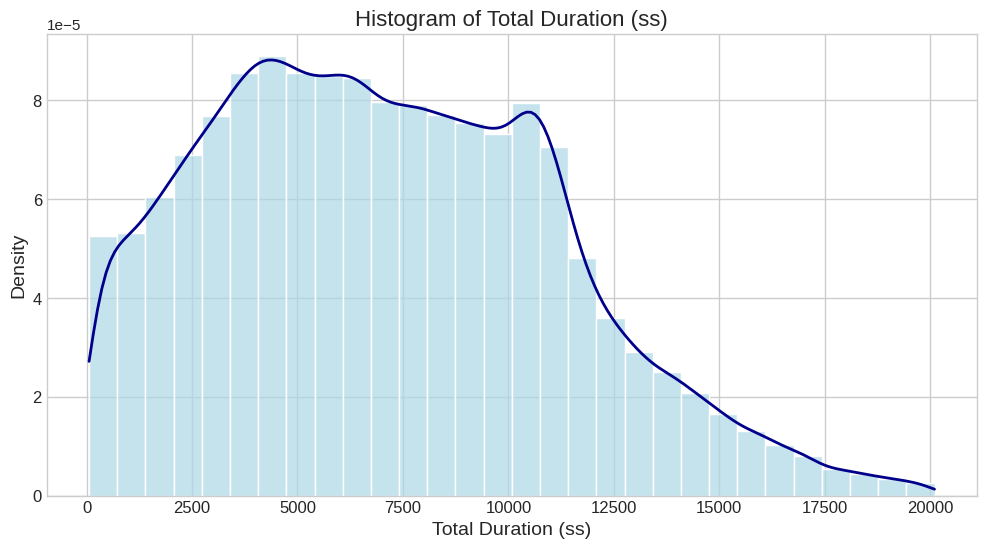


--- Plotting Histogram for Charging Time (ss) ---


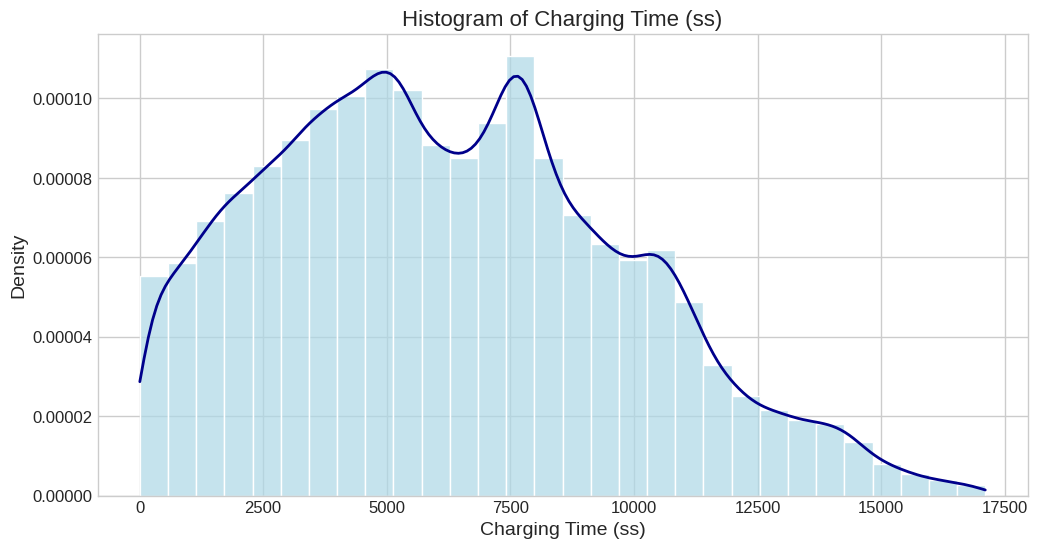


--- Plotting Histogram for Energy (kWh) ---


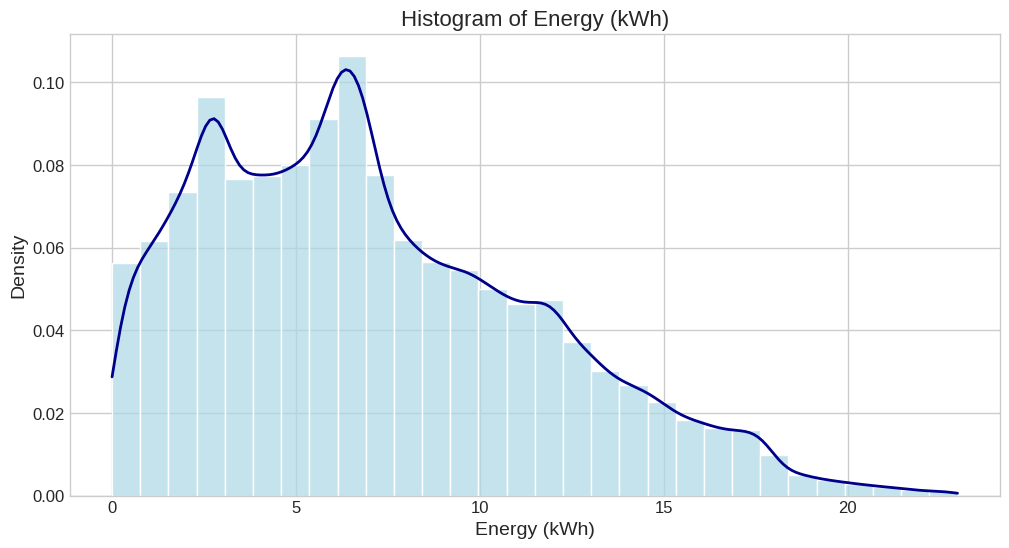


--- Plotting Histogram for GHG Savings (kg) ---


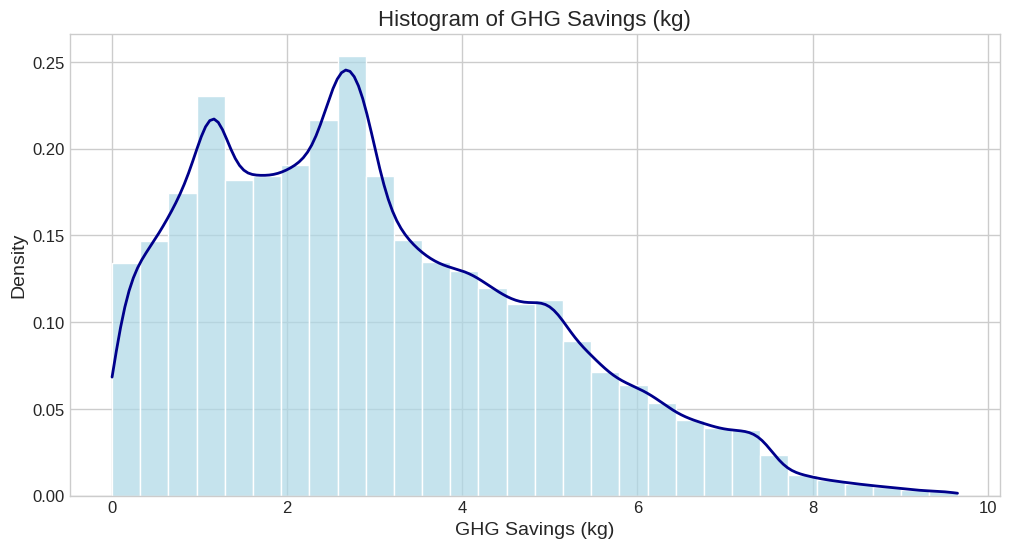

In [ ]:
# Histogram for numeric attributes
numeric_columns = [
    'Total Duration (ss)',
    'Charging Time (ss)',
    'Energy (kWh)',
    'GHG Savings (kg)'
]
for column in numeric_columns:
    print(f"\n--- Plotting Histogram for {column} ---")
    plot_histogram(df, column)

Total duration is generally longer than charging time, suggesting idle time is a prevalent issue. Users may leave their EVs plugged in even after charging is complete, occupying the charging station unnecessarily. Idle time impacts operational efficiency, as the station is occupied but not actively charging. Stations with consistently higher idle times may see lower user satisfaction and revenue. This relationship suggests a need for intervention, such as introducing dynamic pricing, penalties or notifications to improve station turnover.

As expected, there is a proportional relationship between the energy charged and GHG savings, showing how increased utilization of EV stations directly reduces emissions. This could justify promoting higher-capacity EVs as they result in more significant environmental benefits per session.

The peaks in the histograms for total duration, charging time, energy consumption, and GHG savings indicate a clustering of typical charging behaviors:

*   Many sessions cluster around mid-range values (e.g., 6,000–7,000 seconds for charging time and 5–7 kWh for energy).

*   The long tails in all histograms suggest outliers, such as users with unusually long sessions or high energy consumption.

In [ ]:
# Scatter Plot
def plot_scatter(df, x, y):
    plt.style.use(PLOT_STYLE)
    plt.figure(figsize=PLOT_SIZE)
    sns.scatterplot(data=df, x=x, y=y, alpha=TRANSPARENCY)
    plt.title(f'Scatter Plot: {x} vs {y}', fontsize=TITLE_FONT_SIZE)
    plt.xlabel(x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(y, fontsize=LABEL_FONT_SIZE)
    plt.grid(GRID)
    plt.xticks(fontsize=TICK_FONT_SIZE)
    plt.yticks(fontsize=TICK_FONT_SIZE)
    if SAVE_FIGURES:
        plt.savefig(f"{SAVE_FIGURES_DIR}/scatter_{x}_vs_{y}.png")
    plt.show()


--- Plotting Scatter Plot for GHG Savings (kg) vs Energy (kWh) ---


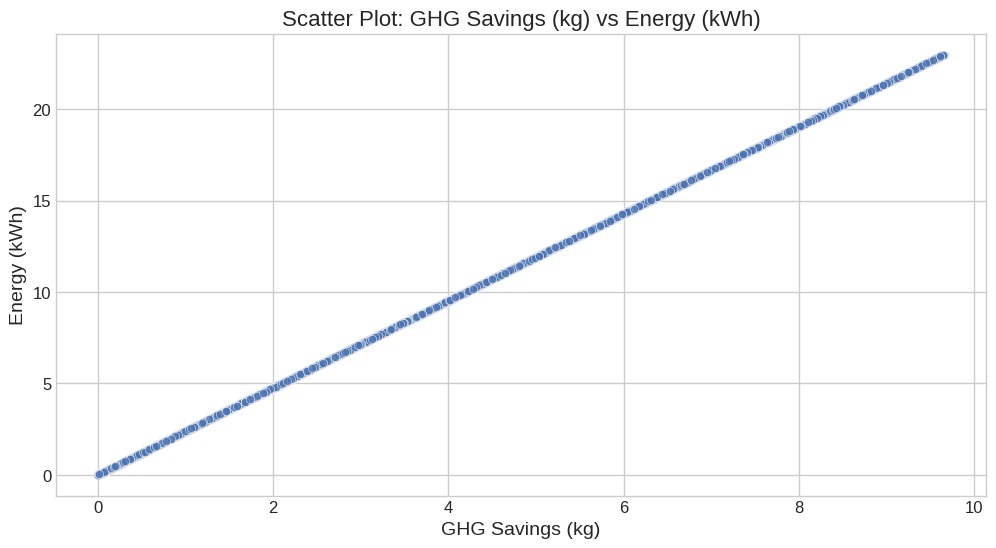

In [ ]:
# Scatter plot for pairwise numeric attributes
scatter_pairs = [
    ('GHG Savings (kg)', 'Energy (kWh)')
]

for x, y in scatter_pairs:
    print(f"\n--- Plotting Scatter Plot for {x} vs {y} ---")
    plot_scatter(df, x, y)

**ENERGY vs GHG SAVINGS**

The linear trend shows that GHG savings increase directly in proportion to energy consumption. This is expected because higher energy consumption reflects more charging, resulting in greater avoidance of GHG emissions from traditional fossil-fueled vehicles.

The linearity suggests a **constant conversion factor** between energy (kWh) and GHG savings (kg). This factor could be derived from the specific grid mix (e.g., renewable energy percentage) in Palo Alto. If the grid becomes greener (more renewable energy), this factor could increase, further boosting GHG savings.

*The data supports a consistent and predictable impact of charging sessions on reducing emissions. This can be used to forecast GHG reductions based on station usage and guide marketing strategies focused on sustainability.*

In [ ]:
# Bar Plot
def plot_bar(df, column):
    plt.style.use(PLOT_STYLE)
    plt.figure(figsize=PLOT_SIZE)
    sns.countplot(data=df, x=column, hue=column, palette=COLOR_PALETTE, legend=False)
    plt.title(f'Bar Plot of {column}', fontsize=TITLE_FONT_SIZE)
    plt.xlabel(column, fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Count', fontsize=LABEL_FONT_SIZE)
    plt.grid(GRID)
    plt.xticks(fontsize=TICK_FONT_SIZE, rotation=90)
    plt.yticks(fontsize=TICK_FONT_SIZE)
    if SAVE_FIGURES:
        plt.savefig(f"{SAVE_FIGURES_DIR}/barplot_{column}.png")
    plt.show()


--- Plotting Bar Plot for Hour of the Day ---


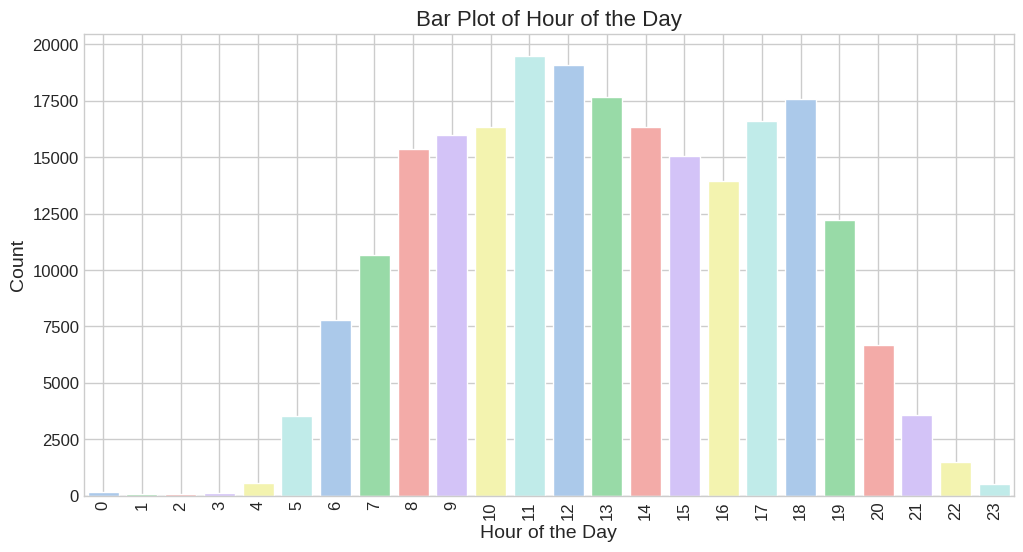


--- Plotting Bar Plot for Time of Day ---


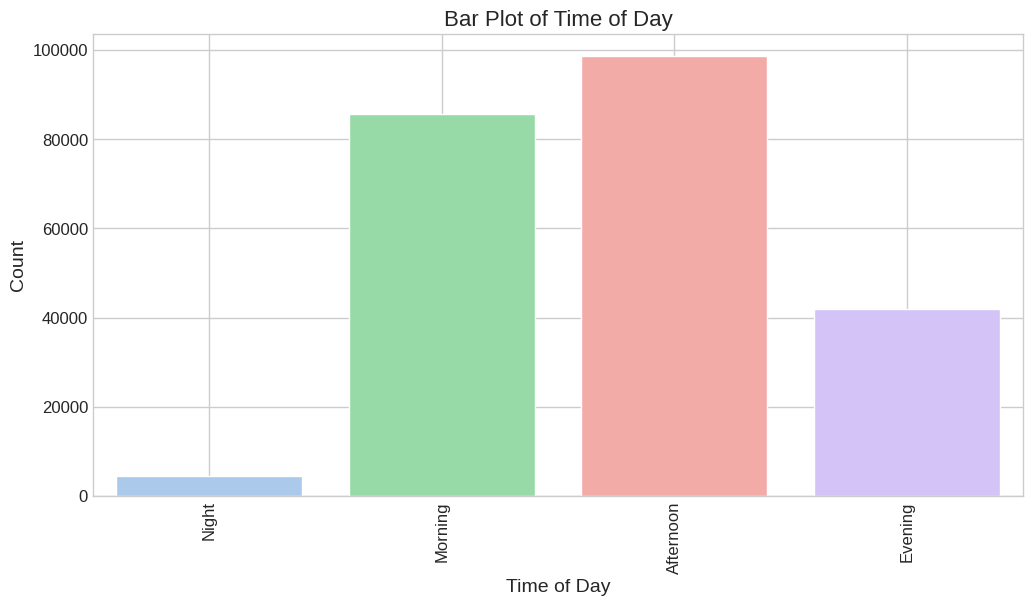


--- Plotting Bar Plot for Day of the Week ---


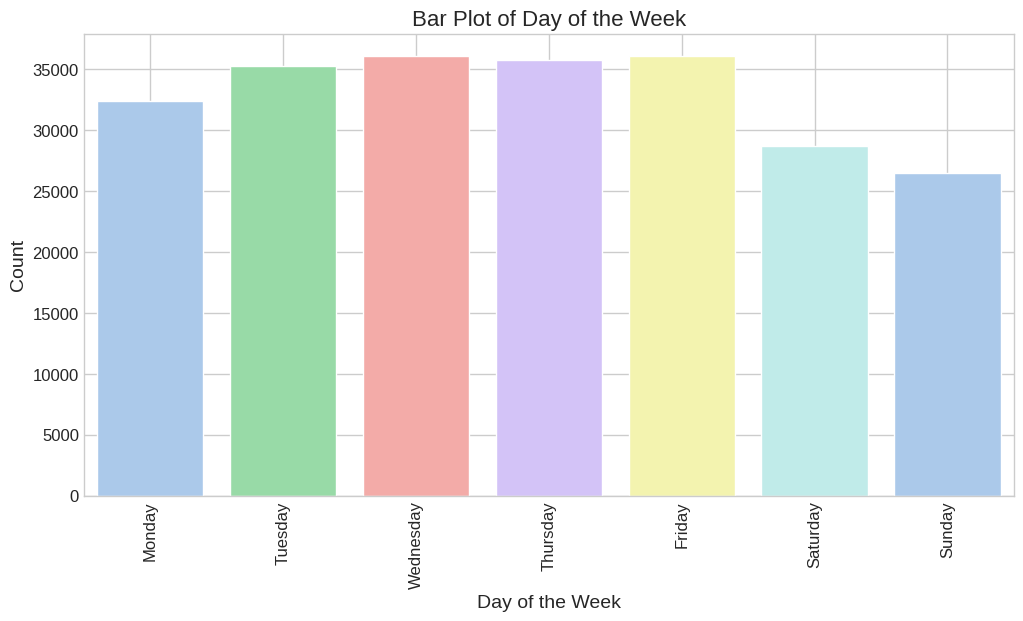


--- Plotting Bar Plot for Month ---


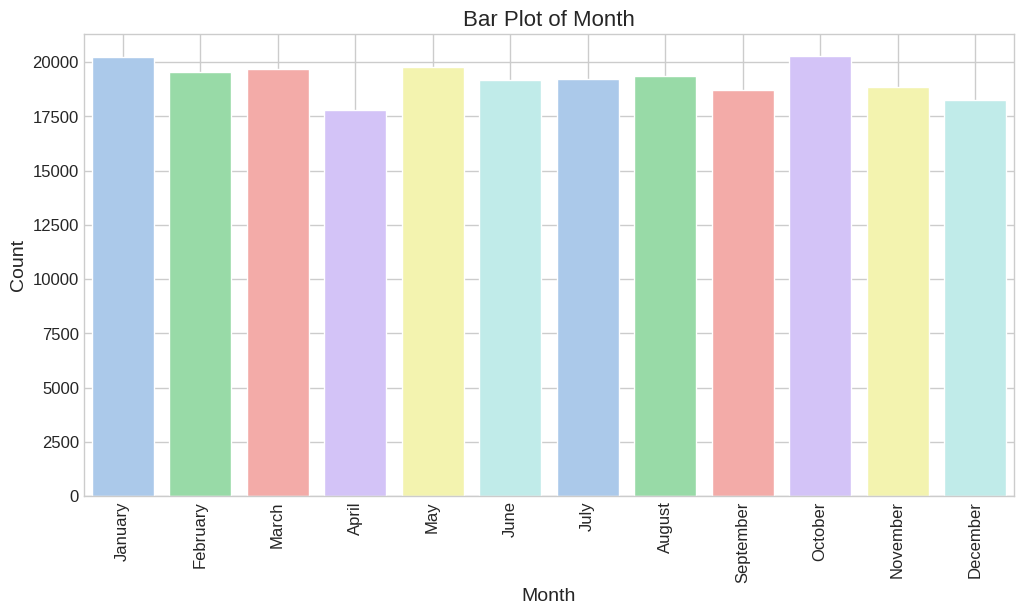


--- Plotting Bar Plot for Session Length ---


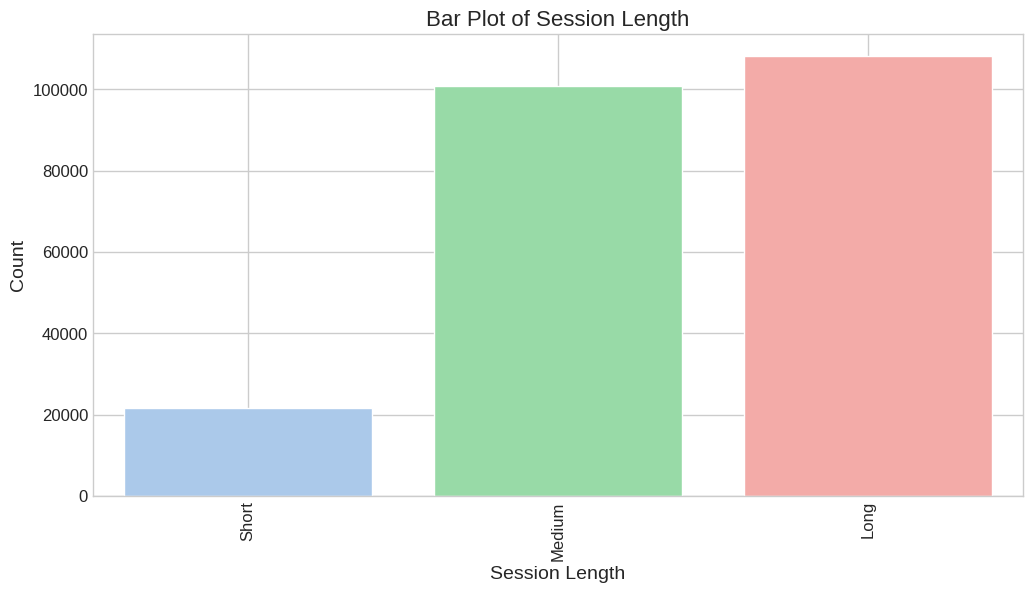

In [ ]:
# Bar plot for categorical attributes
categorical_columns_to_plot = [
    'Hour of the Day',
    'Time of Day',
    'Day of the Week',
    'Month',
    'Session Length'
]

for column in categorical_columns_to_plot:
    print(f"\n--- Plotting Bar Plot for {column} ---")
    # Sort bars for specific columns
    if column == 'Day of the Week':
        df['Day of the Week'] = pd.Categorical(df['Day of the Week'], categories=DAY_OF_WEEK_ORDER, ordered=True)
    elif column == 'Month':
        df['Month'] = pd.Categorical(df['Month'], categories=MONTH_ORDER, ordered=True)
    plot_bar(df, column)

The data reveals clear temporal patterns in EV charging behaviors, driven by user routines and charging needs. Charging activity peaks during the late morning and afternoon hours, with significantly lower utilization during nighttime, reflecting well the typical work and commute schedules. On a weekly scale, weekday activity is higher than weekends, with Friday showing the highest usage, likely reflecting the end-of-week travel preparations. Monthly distributions indicate relatively consistent usage during the year, suggesting stable demand regardless of seasonal variations.
Lastly, session lengths fall into medium and long categories, likely reflecting workplace or home-based charging, while shorter sessions are less common and may correspond to opportunistic charging stops (e.g. lunch-breakes).

**Key Underlying Relationships**

*   **Time of Day**: High activity in the afternoon suggests a strong preference for workplace charging or users capitalizing on midday opportunities.
*   **Day of the Week**: Weekday dominance, especially Friday, indicates a mix of routine and pre-weekend charging behavior.

*   **Consistency Across Months**: Stable monthly activity implies no strong seasonal dependence, potentially reflecting the reliability of EV infrastructure and consistent user demand

***Strategic Recommendation***: Focus on optimizing infrastructure during peak hours and days, while ensuring support for medium and long charging needs.

In [ ]:
# Heatmap
def plot_heatmap(df, columns):
    plt.style.use(PLOT_STYLE)
    plt.figure(figsize=PLOT_SIZE)
    correlation_matrix = df[columns].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap', fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICK_FONT_SIZE, rotation=90)
    plt.yticks(fontsize=TICK_FONT_SIZE)
    if SAVE_FIGURES:
        plt.savefig(f"{SAVE_FIGURES_DIR}/heatmap_correlation.png")
    plt.show()



--- Plotting Heatmap for Numeric Columns ---


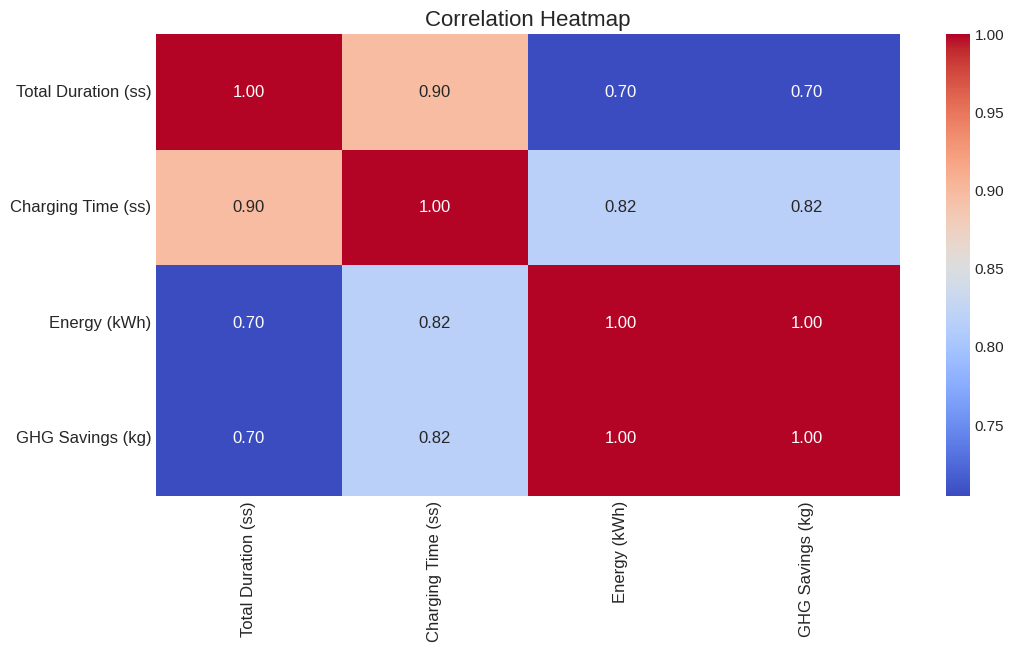

In [ ]:
# Heatmap for correlations between numeric columns
print("\n--- Plotting Heatmap for Numeric Columns ---")
plot_heatmap(df, numeric_columns)

*   A correlation coefficient of 0.90 indicates that charging time is a major component of total duration. However, the presence of idle time introduces some variation.

*   Perfect Correlation Between Energy (kWh) and GHG Savings (kg) as mentioned before.

*  The correlation between Charging Time and Energy/GHG Savings is 0.82, while Total Duration and Energy/GHG Savings have a weaker correlation of 0.70. This indicates that while longer sessions typically consume more energy and lead to higher GHG savings, the inclusion of idle time in the total duration weakens the correlation.

In [ ]:
# Function for Categorical Heatmaps
def plot_heatmap_aggregated(df, row_col, col_col, value_col, aggfunc='sum', cmap='coolwarm'):
    # Pivot table with explicit 'observed' parameter
    pivot_table = df.pivot_table(values=value_col, index=row_col, columns=col_col, aggfunc=aggfunc, observed=True)

    plt.style.use(PLOT_STYLE)
    plt.figure(figsize=(15, 7))
    sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap=cmap, linewidths=0.5, annot_kws={"fontsize": 8, "rotation": 30})
    plt.title(f'Heatmap of {value_col} ({aggfunc.capitalize()}) by {row_col} and {col_col}', fontsize=TITLE_FONT_SIZE)
    plt.xlabel(col_col, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(row_col, fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICK_FONT_SIZE, rotation=0)
    plt.yticks(fontsize=TICK_FONT_SIZE)
    plt.grid(GRID)
    if SAVE_FIGURES:
        plt.savefig(f"{SAVE_FIGURES_DIR}/heatmap_{value_col}_by_{row_col}_and_{col_col}.png")
    plt.tight_layout()
    plt.show()


--- Plotting Heatmap for Count by Day of the Week and Hour of the Day (Sum) ---


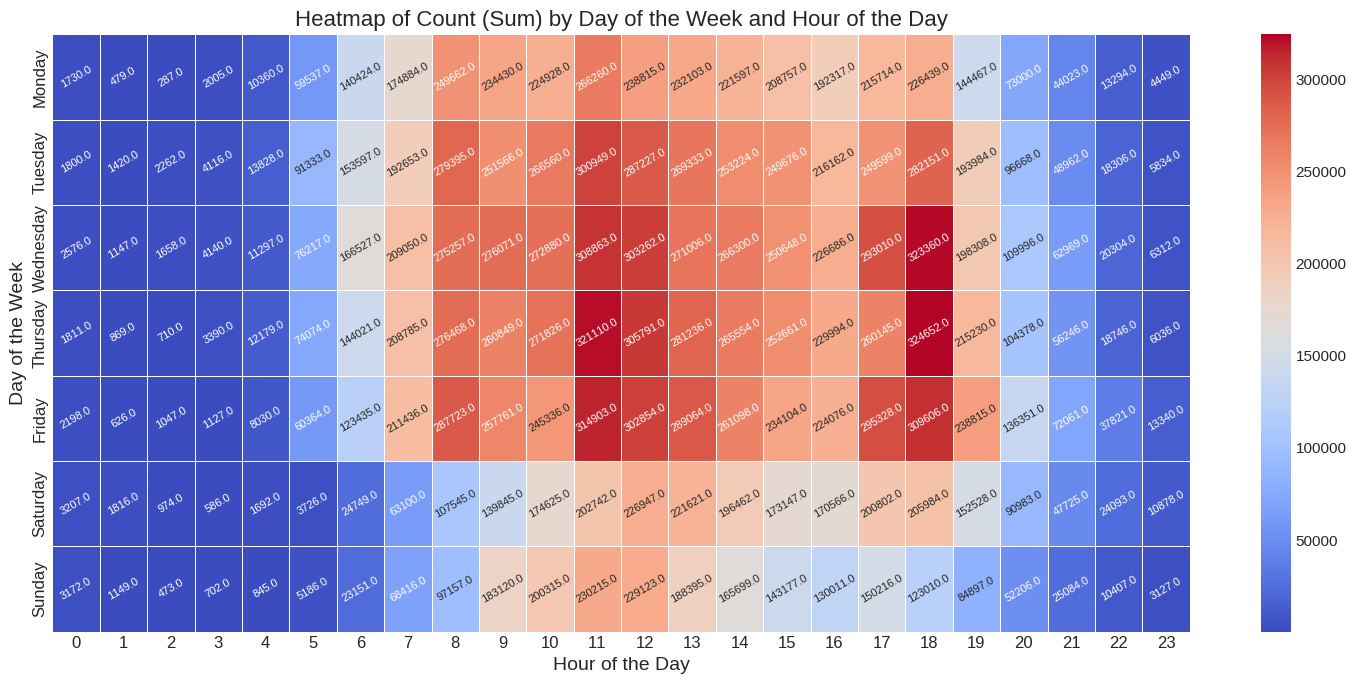

In [ ]:
# Heatmap by Categorical Aggregations
heatmap_pairs = [
    ('Day of the Week', 'Hour of the Day', 'Count', 'sum')
]

# Execute for each pair
for row_col, col_col, value_col, aggfunc in heatmap_pairs:
    print(f"\n--- Plotting Heatmap for {value_col} by {row_col} and {col_col} ({aggfunc.capitalize()}) ---")
    # Sort for specific columns
    if column == 'Day of the Week':
        df['Day of the Week'] = pd.Categorical(df['Day of the Week'], categories=DAY_OF_WEEK_ORDER, ordered=True)
    elif column == 'Month':
        df['Month'] = pd.Categorical(df['Month'], categories=MONTH_ORDER, ordered=True)
    plot_heatmap_aggregated(df, row_col, col_col, value_col, aggfunc)

The heatmaps reveal a strong alignment between charging demand and typical workday schedules, with peak activity occurring on weekdays, especially during **morning hours (7–9 AM)** and **afternoon hours (3–5 PM)**. This pattern highlights the dominance of workplace and commuter charging during these hours. In response to high demand, fees are dynamically adjusted, with the highest prices observed during these peak times, where electricity is more expensive.  On the other hand, weekends show reduced charging activity and more consistent, lower fees, suggesting more flexible charging behavior. Late-night usage remains minimal across all days, with significantly lower fees, likely to encourage off-peak charging.

In [ ]:
# Time Series
def plot_line(df, x, y, interval='ME', rolling_window=None):
    plt.style.use(PLOT_STYLE)
    plt.figure(figsize=PLOT_SIZE)

    # Ensure the x column is datetime
    if not pd.api.types.is_datetime64_any_dtype(df[x]):
        raise TypeError(f"The x-axis column '{x}' must be a datetime type.")

    # Resample and aggregate data
    df_resampled = df[[x, y]].set_index(x).resample(interval).mean().reset_index()

    # Apply rolling average if specified
    if rolling_window:
        df_resampled[y] = df_resampled[y].rolling(rolling_window).mean()

    # Plot the line plot
    sns.lineplot(data=df_resampled, x=x, y=y, alpha=TRANSPARENCY, color='darkblue', linewidth=2)

    plt.title(f'Time Series: {y} Over {x}', fontsize=TITLE_FONT_SIZE)
    plt.xlabel(x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(y, fontsize=LABEL_FONT_SIZE)
    plt.grid(GRID)
    plt.xticks(fontsize=TICK_FONT_SIZE, rotation=45)
    plt.yticks(fontsize=TICK_FONT_SIZE)

    if SAVE_FIGURES:
        plt.savefig(f"{SAVE_FIGURES_DIR}/time_series_{x}_vs_{y}.png")

    plt.show()


--- Plotting Time Series for Start Date vs Count ---


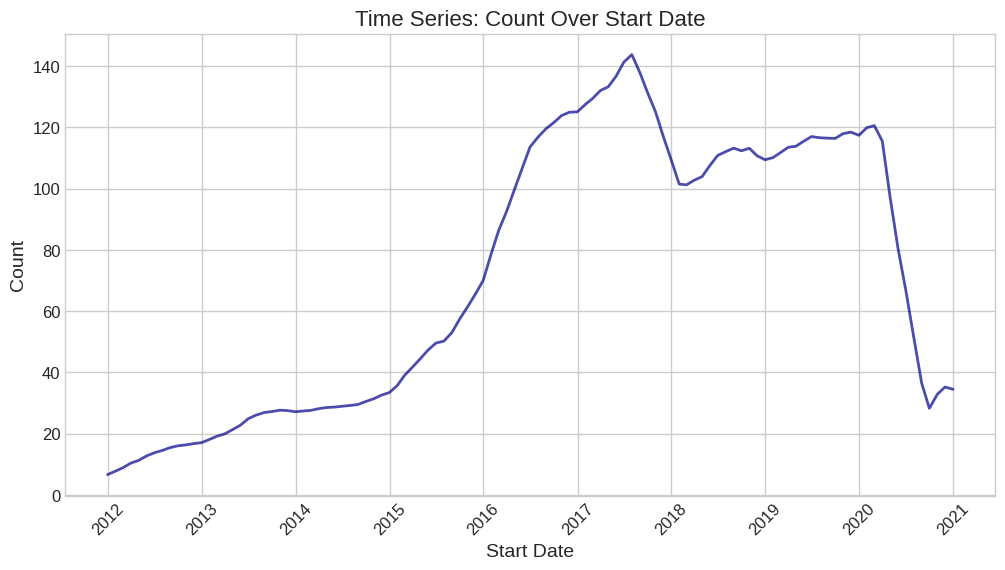


--- Plotting Time Series for Start Date vs Fee ---


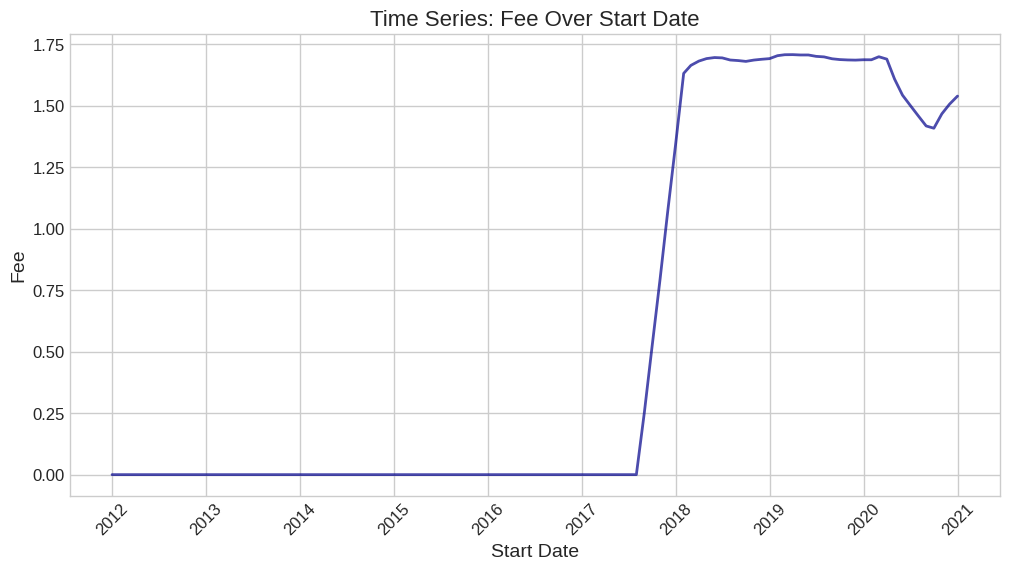


--- Plotting Time Series for Start Date vs Total Duration (ss) ---


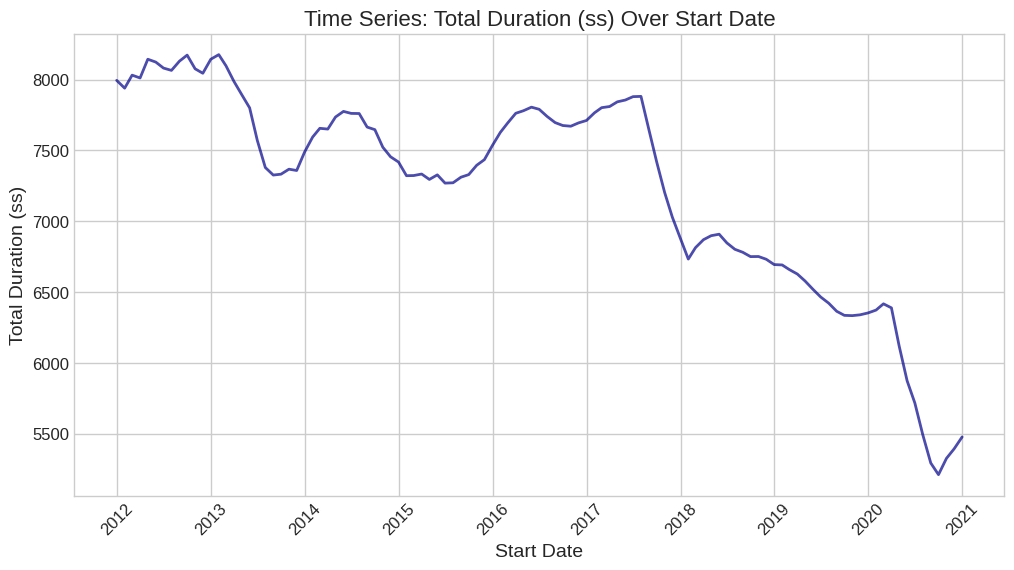

In [ ]:
# Line plot for time series attributes
time_series_pairs = [
    ('Start Date', 'Count'),
    ('Start Date', 'Fee'),
    ('Start Date', 'Total Duration (ss)')
]

for x, y in time_series_pairs:
    print(f"\n--- Plotting Time Series for {x} vs {y} ---")
    plot_line(df, x, y, interval='ME', rolling_window=6)

The data shows clear changes in charging behavior over time, driven by key events and policies. From 2012 to 2017, the number of charging sessions steadily increased. This growth was likely due to free charging being available and the growing popularity of electric vehicles (EVs). A major boost in usage around 2015 coincides with the launch of Tesla’s Model S and Model X, which significantly increased EV adoption and the need for public charging stations.

In 2017, the introduction of fees led to a noticeable drop in charging sessions. This suggests that people were more likely to charge frequently when it was free. After fees were introduced, users seemed to adjust their behavior, charging less often or switching to home charging options. These trends suggest that charging providers need to balance costs and user needs. Strategies like offering discounts during off-peak times or loyalty programs could help keep demand steady while covering operational expenses. The increase in charging events during the free phase also shows how incentives can play a key role in promoting EV adoption and infrastructure use.

In addition also the mean charging period is decreasing over time. As we move towards nowadays, we can see the total duration of each single charging event is really low compared to what it was in the beginning, this can be a clear sign of tech improvement in the EV stations. Right now the majority of EVs stations have ‘fast-charging’, which allows car to complete a full charge in a considerably reduce time than before.

# **New Dataset**
01/01/2016 00:00:00 - 31/01/2019 23:59:59

In [ ]:
# Filter the dataset for data between 1-1-2016 00:00:00 and 31-12-2019 23:59:59
new_df = df[
    (df['Start Date'] >= pd.Timestamp('2016-01-01 00:00:00')) &
    (df['Start Date'] <= pd.Timestamp('2019-12-31 23:59:59'))
]

# Display the shape of the filtered dataset
print(f"New dataset contains {new_df.shape[0]} rows and {new_df.shape[1]} columns.")

new_df.head()

New dataset contains 166890 rows and 38 columns.


Station Name          Start Date Start Time Zone  \
52819   PALO ALTO CA / BRYANT #2 2016-01-01 09:26:00             PST   
52820   PALO ALTO CA / BRYANT #1 2016-01-01 09:55:00             PST   
52821      PALO ALTO CA / MPL #6 2016-01-01 10:13:00             PST   
52822  PALO ALTO CA / WEBSTER #1 2016-01-01 10:42:00             PST   
52823   PALO ALTO CA / BRYANT #1 2016-01-01 11:06:00             PST   

                 End Date Transaction Date (Pacific Time)  \
52819 2016-01-01 11:19:00                  1/1/2016 11:19   
52820 2016-01-01 10:49:00                  1/1/2016 10:49   
52821 2016-01-01 12:05:00                  1/1/2016 12:06   
52822 2016-01-01 13:59:00                  1/1/2016 13:59   
52823 2016-01-01 12:12:00                  1/1/2016 12:12   

      Total Duration (hh:mm:ss) Charging Time (hh:mm:ss)  Energy (kWh)  \
52819                   1:53:20                  1:29:35      2.744629   
52820                   0:54:13                  0:53:55      5.233959   
52821                   1:52:40                  1:52:29     11.342517   
52822                   3:16:27                  3:16:09     16.388630   
52823                   1:06:42                  1:06:35      6.559548   

       GHG Savings (kg)  Gasoline Savings (gallons)  ... Time of Day Weekend  \
52819             1.153                       0.344  ...     Morning   False   
52820             2.198                       0.657  ...     Morning   False   
52821             4.764                       1.423  ...     Morning   False   
52822             6.883                       2.057  ...     Morning   False   
52823             2.755                       0.823  ...     Morning   False   

      Idle Time (seconds) Charging Efficiency (kWh/sec)  Cost per kWh  \
52819              1425.0                      0.000511           0.0   
52820                18.0                      0.001618           0.0   
52821                11.0                      0.001681           0.0   
52822                18.0                      0.001393           0.0   
52823                 7.0                      0.001642           0.0   

       Cost per Minute  GHG Savings Rate Gasoline Savings per kWh  \
52819              0.0          0.420093                 0.125336   
52820              0.0          0.419950                 0.125526   
52821              0.0          0.420013                 0.125457   
52822              0.0          0.419986                 0.125514   
52823              0.0          0.419998                 0.125466   

      Session Length Count  
52819         Medium    37  
52820         Medium    37  
52821         Medium    37  
52822           Long    37  
52823         Medium    37  

[5 rows x 38 columns]

In [ ]:
# Save the new dataset as a CSV file
new_df.to_csv('dataset_2016_2019.csv', index=False)

# **Mandatory Component: Clustering**

In [ ]:
def create_clustering_df(df, required_columns):
    # Include required columns
    selected_columns = required_columns.copy()

    # Filter the dataframe with the selected columns
    clustering_df = df[selected_columns].copy()
    print(f"Clustering DataFrame created with columns: {selected_columns}")

    return clustering_df

# Required columns
required_columns = [
    'Start Date',
    'Energy (kWh)',
    'Charging Time (ss)',
    'Total Duration (ss)',
    'Fee',
    'Cost per kWh',
    'Cost per Minute',
    'Charging Efficiency (kWh/sec)',
    'Idle Time (seconds)',
    'GHG Savings (kg)',
    'Gasoline Savings (gallons)',
    'GHG Savings Rate',
    'Gasoline Savings per kWh',
    'Hour of the Day',
    'Weekend',
    'Count'
]

# Create clustering dataframe
clustering_df = create_clustering_df(new_df, required_columns)

Clustering DataFrame created with columns: ['Start Date', 'Energy (kWh)', 'Charging Time (ss)', 'Total Duration (ss)', 'Fee', 'Cost per kWh', 'Cost per Minute', 'Charging Efficiency (kWh/sec)', 'Idle Time (seconds)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'GHG Savings Rate', 'Gasoline Savings per kWh', 'Hour of the Day', 'Weekend', 'Count']


In [ ]:
def preprocess_clustering_data(df, numeric_columns, categorical_columns):
    # Step 1: Standardize numeric columns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numeric_columns])
    scaled_df = pd.DataFrame(scaled_data, columns=numeric_columns, index=df.index)

    # Step 2: One-hot encode categorical columns
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
    encoded_data = encoder.fit_transform(df[categorical_columns])
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=encoder.get_feature_names_out(categorical_columns),
        index=df.index
    )

    # Step 3: Combine scaled numeric and encoded categorical data
    preprocessed_df = pd.concat([scaled_df, encoded_df], axis=1)

    return preprocessed_df

# Define numeric and categorical columns
numeric_columns = clustering_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = clustering_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocess the data
clustering_preprocessed_df = preprocess_clustering_data(clustering_df, numeric_columns, categorical_columns)

# Display the resulting dataset
print("\n--- Preprocessed Clustering Data ---")
print(clustering_preprocessed_df.head())


--- Preprocessed Clustering Data ---
       Energy (kWh)  Charging Time (ss)  Total Duration (ss)       Fee  \
52819     -0.996297           -0.246298            -0.078287 -0.843456   
52820     -0.449450           -0.854886            -0.957843 -0.843456   
52821      0.892457            0.144450            -0.088206 -0.843456   
52822      2.000970            1.572074             1.158349 -0.843456   
52823     -0.158249           -0.638752            -0.772112 -0.843456   

       Cost per kWh  Cost per Minute  Charging Efficiency (kWh/sec)  \
52819     -0.162115        -0.692147                      -1.387213   
52820     -0.162115        -0.692147                       0.879224   
52821     -0.162115        -0.692147                       1.007573   
52822     -0.162115        -0.692147                       0.417886   
52823     -0.162115        -0.692147                       0.928396   

       Idle Time (seconds)  GHG Savings (kg)  Gasoline Savings (gallons)  \
52819         

In [ ]:
def plot_elbow_method(data, max_k=10, attributes=None):
    if attributes is None:
        attributes = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

    data_to_cluster = data[attributes]
    wcss = []

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_to_cluster)
        wcss.append(kmeans.inertia_)  # WCSS/inertia for the current number of clusters

    # Plot the WCSS values
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--', color='b')
    plt.title('Elbow Method for Optimal Clusters', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Number of Clusters (k)', fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=LABEL_FONT_SIZE)
    plt.grid(GRID)
    if SAVE_FIGURES:
        plt.savefig(f"{SAVE_FIGURES_DIR}/elbow_plot.png")
    plt.tight_layout()
    plt.show()


--- Executing Elbow Method for Optimal Clusters ---


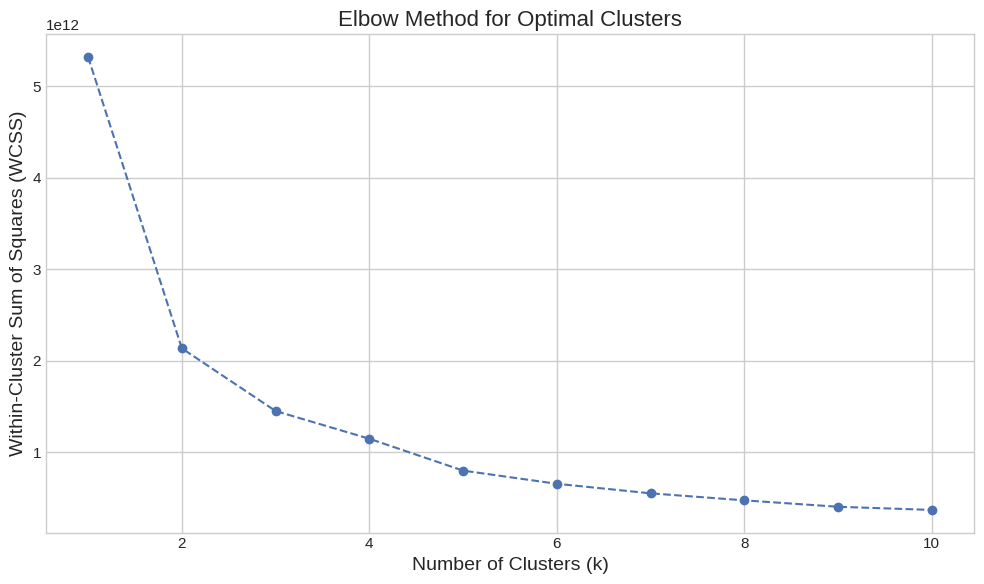

In [ ]:
# Elbow Method Execution
print("\n--- Executing Elbow Method for Optimal Clusters ---")

# Define attributes for clustering
attributes_for_clustering = [
    'Energy (kWh)',
    'Charging Time (ss)',
    'Total Duration (ss)',
    'Fee',
    'Cost per kWh',
    'Cost per Minute',
    'Charging Efficiency (kWh/sec)',
    'Idle Time (seconds)',
    'GHG Savings (kg)',
    'Gasoline Savings (gallons)',
    'GHG Savings Rate',
    'Gasoline Savings per kWh',
    'Hour of the Day',
    'Weekend'
]

# Call the elbow method function
plot_elbow_method(data=clustering_df, max_k=10, attributes=attributes_for_clustering)

In [ ]:
'''from sklearn.metrics import silhouette_score

def calculate_silhouette_scores(data, max_k=10, attributes=None):
    if attributes is None:
        attributes = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

    data_to_cluster = data[attributes]
    silhouette_scores = {}

    for k in range(2, max_k + 1):  # Silhouette score is not defined for k=1
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data_to_cluster)
        score = silhouette_score(data_to_cluster, cluster_labels)
        silhouette_scores[k] = score
        print(f"Silhouette Score for {k} clusters: {score:.4f}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', linestyle='--', color='g')
    plt.title('Silhouette Scores for Different Clusters', fontsize=TITLE_FONT_SIZE)
    plt.xlabel('Number of Clusters (k)', fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Silhouette Score', fontsize=LABEL_FONT_SIZE)
    plt.grid(GRID)
    if SAVE_FIGURES:
        plt.savefig(f"{SAVE_FIGURES_DIR}/silhouette_scores.png")
    plt.tight_layout()
    plt.show()

    return silhouette_scores

# Calculate silhouette scores
print("\n--- Calculating Silhouette Scores ---")
silhouette_scores = calculate_silhouette_scores(data=clustering_preprocessed_df, max_k=10, attributes=attributes_for_clustering)'''

'''
--- Calculating Silhouette Scores ---
Silhouette Score for 2 clusters: 0.5561
Silhouette Score for 3 clusters: 0.4877
Silhouette Score for 4 clusters: 0.4655
Silhouette Score for 5 clusters: 0.4477
Silhouette Score for 6 clusters: 0.4619
Silhouette Score for 7 clusters: 0.4502
Silhouette Score for 8 clusters: 0.4261
Silhouette Score for 9 clusters: 0.4431
Silhouette Score for 10 clusters: 0.4492
'''

'\n--- Calculating Silhouette Scores ---\nSilhouette Score for 2 clusters: 0.5561\nSilhouette Score for 3 clusters: 0.4877\nSilhouette Score for 4 clusters: 0.4655\nSilhouette Score for 5 clusters: 0.4477\nSilhouette Score for 6 clusters: 0.4619\nSilhouette Score for 7 clusters: 0.4502\nSilhouette Score for 8 clusters: 0.4261\nSilhouette Score for 9 clusters: 0.4431\nSilhouette Score for 10 clusters: 0.4492\n'

In [ ]:
def apply_kmeans_clustering(df, n_clusters, random_state=42):
    # Apply KMeans clustering
    print(f"\n--- Applying KMeans Clustering with {n_clusters} clusters ---")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(df)

    # Add cluster labels to the dataset
    df['Cluster'] = cluster_labels

    print(f"Cluster Centers:\n{kmeans.cluster_centers_}")
    print(f"Inertia: {kmeans.inertia_}")

    return df, kmeans

def plot_kmeans_scatterplot(df, x_col, y_col, cluster_col='Cluster'):
    plt.figure(figsize=PLOT_SIZE)
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=cluster_col, palette=COLOR_PALETTE, s=50, alpha=0.7)
    plt.title(f"KMeans Clusters: {x_col} vs {y_col}", fontsize=TITLE_FONT_SIZE)
    plt.xlabel(x_col, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(y_col, fontsize=LABEL_FONT_SIZE)
    plt.legend(title="Cluster", fontsize=TICK_FONT_SIZE, loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.grid(True)
    plt.show()

# Apply KMeans clustering
n_clusters = 2
clustering_with_kmeans, kmeans_model = apply_kmeans_clustering(clustering_preprocessed_df, n_clusters=n_clusters)

# Merge the clustering labels back into the original dataset
new_df = new_df.merge(clustering_with_kmeans[['Cluster']], left_index=True, right_index=True, how='left')


--- Applying KMeans Clustering with 2 clusters ---
Cluster Centers:
[[ 0.95803728  0.90497616  0.83906916  0.45290072 -0.01721809  0.01081037
   0.19199147  0.11184576  0.95803725  0.9580377   0.00205442  0.01391102
   0.11277094]
 [-0.67506088 -0.63767247 -0.59123248 -0.31912699  0.01213237 -0.0076173
  -0.13528276 -0.07880977 -0.67506085 -0.67506117 -0.0014476  -0.00980211
  -0.07946168]]
Inertia: 1635172.5750951



--- Visualizing Pair Plot for Clusters ---


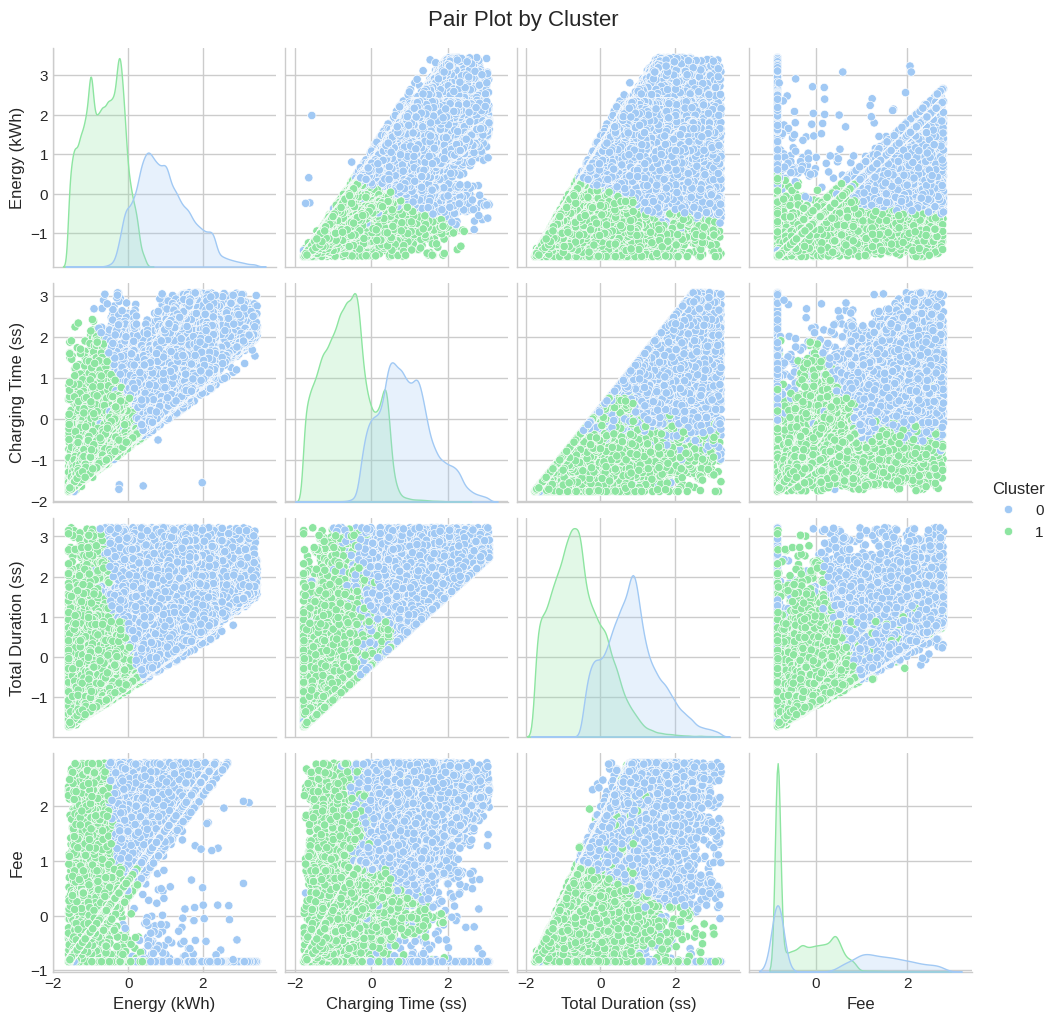

In [ ]:
def plot_pairplot_clusters(df, attributes, cluster_col='Cluster'):
    sns.pairplot(df[attributes + [cluster_col]], hue=cluster_col, palette=COLOR_PALETTE, diag_kind="kde", height=2.5)
    plt.suptitle("Pair Plot by Cluster", fontsize=TITLE_FONT_SIZE, y=1.02)
    plt.show()

# Attributes for pairplot visualization
pairplot_attributes = ['Energy (kWh)', 'Charging Time (ss)', 'Total Duration (ss)', 'Fee']

# Plot pairplot for the clusters
print("\n--- Visualizing Pair Plot for Clusters ---")
plot_pairplot_clusters(clustering_with_kmeans, pairplot_attributes)

In [ ]:
# List of numerical columns to aggregate
numerical_columns = [
    'Total Duration (ss)',
    'Charging Time (ss)',
    'Idle Time (seconds)',
    'Energy (kWh)',
    'GHG Savings (kg)',
    'Gasoline Savings (gallons)',
    'Fee',
    'Charging Efficiency (kWh/sec)',
    'Cost per kWh',
    'Cost per Minute',
]

# Define the aggregation functions
aggregation_functions = ['mean', 'median', 'sum', 'min', 'max']

# Aggregate statistics for numerical columns
aggregated_data = new_df.groupby('Station Name')[numerical_columns].agg(aggregation_functions)

# Flatten the MultiIndex created by agg()
aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns]

# Reset the index for a cleaner DataFrame
aggregated_data = aggregated_data.reset_index()

# Add the count of sessions for each station
aggregated_data['Session_Count'] = new_df.groupby('Station Name').size().values

# Categorical columns to aggregate
categorical_columns = ['Port Type', 'Plug Type', 'County', 'Model Number']

# Initialize a DataFrame to store mode percentages
mode_percentage_data = pd.DataFrame()

# Aggregate categorical columns by mode and calculate percentages
for col in categorical_columns:
    mode_data = new_df.groupby('Station Name')[col].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
    mode_percentage = (
        new_df.groupby('Station Name')[col]
        .apply(lambda x: (x.value_counts(normalize=True).iloc[0] if not x.value_counts().empty else 0) * 100)
    )
    mode_percentage_data[col] = mode_data
    mode_percentage_data[f'{col}_Mode_Percentage'] = mode_percentage

# Merge categorical mode and percentage data with the existing aggregated_data
aggregated_data = aggregated_data.merge(mode_percentage_data, on='Station Name', how='left')

In [ ]:
# Step 1: Create a unique ID column in aggregated_data to track rows
aggregated_data['ID'] = aggregated_data.index

# Step 2: Select only the numeric columns for clustering
numeric_columns_for_clustering = aggregated_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Preprocess the numeric data only
aggregated_numeric_preprocessed_df = preprocess_clustering_data(aggregated_data, numeric_columns_for_clustering, [])

# Step 3: Apply KMeans clustering to the numeric data
n_clusters = 3  # Adjust as needed
aggregated_with_kmeans, kmeans_model_aggregated = apply_kmeans_clustering(aggregated_numeric_preprocessed_df, n_clusters=n_clusters)

# Step 4: Merge the cluster column back into the original aggregated_data using 'ID'
# Ensure that the clustering result has an 'ID' column
aggregated_with_kmeans['ID'] = aggregated_data['ID']

# Merge the 'Cluster' column back into the original aggregated_data
aggregated_data = aggregated_data.merge(aggregated_with_kmeans[['ID', 'Cluster']], on='ID', how='left')

# Drop the 'ID' column after merging if you don't need it
aggregated_data = aggregated_data.drop(columns=['ID'])


--- Applying KMeans Clustering with 3 clusters ---
Cluster Centers:
[[ 5.07544791e-01  4.90801670e-01  1.17302033e+00 -3.15888615e-01
   4.72911803e-01  4.26870439e-01  4.21543746e-01  1.16378457e+00
  -3.57131448e-01  5.37435360e-01  3.05504470e-01  7.18653069e-01
   1.20795682e+00 -3.44690994e-01  5.28373952e-01  1.94836615e-01
   1.26388331e-01  1.14183880e+00 -3.76016483e-01  4.64017900e-01
   1.94840325e-01  1.26414327e-01  1.14183923e+00 -3.90938091e-01
   4.63931169e-01  1.94841908e-01  1.26687205e-01  1.14184068e+00
  -3.48366507e-01  4.64276287e-01 -1.98907653e-01 -3.37931952e-01
   1.00302838e+00  0.00000000e+00  2.79441674e-01 -4.64483421e-01
  -1.11246345e-01  1.11293334e+00 -3.30107884e-01  5.79450485e-01
  -1.62517765e-01 -6.12083242e-02  9.72165540e-01  0.00000000e+00
   3.70530716e-01 -2.10864373e-01 -2.00143508e-01  9.84867083e-01
   0.00000000e+00  3.57293354e-01  1.14199702e+00  3.58687650e-01
   3.58687650e-01 -7.43821137e-02 -1.09613804e-01  2.00494648e-01]
 [-1.4

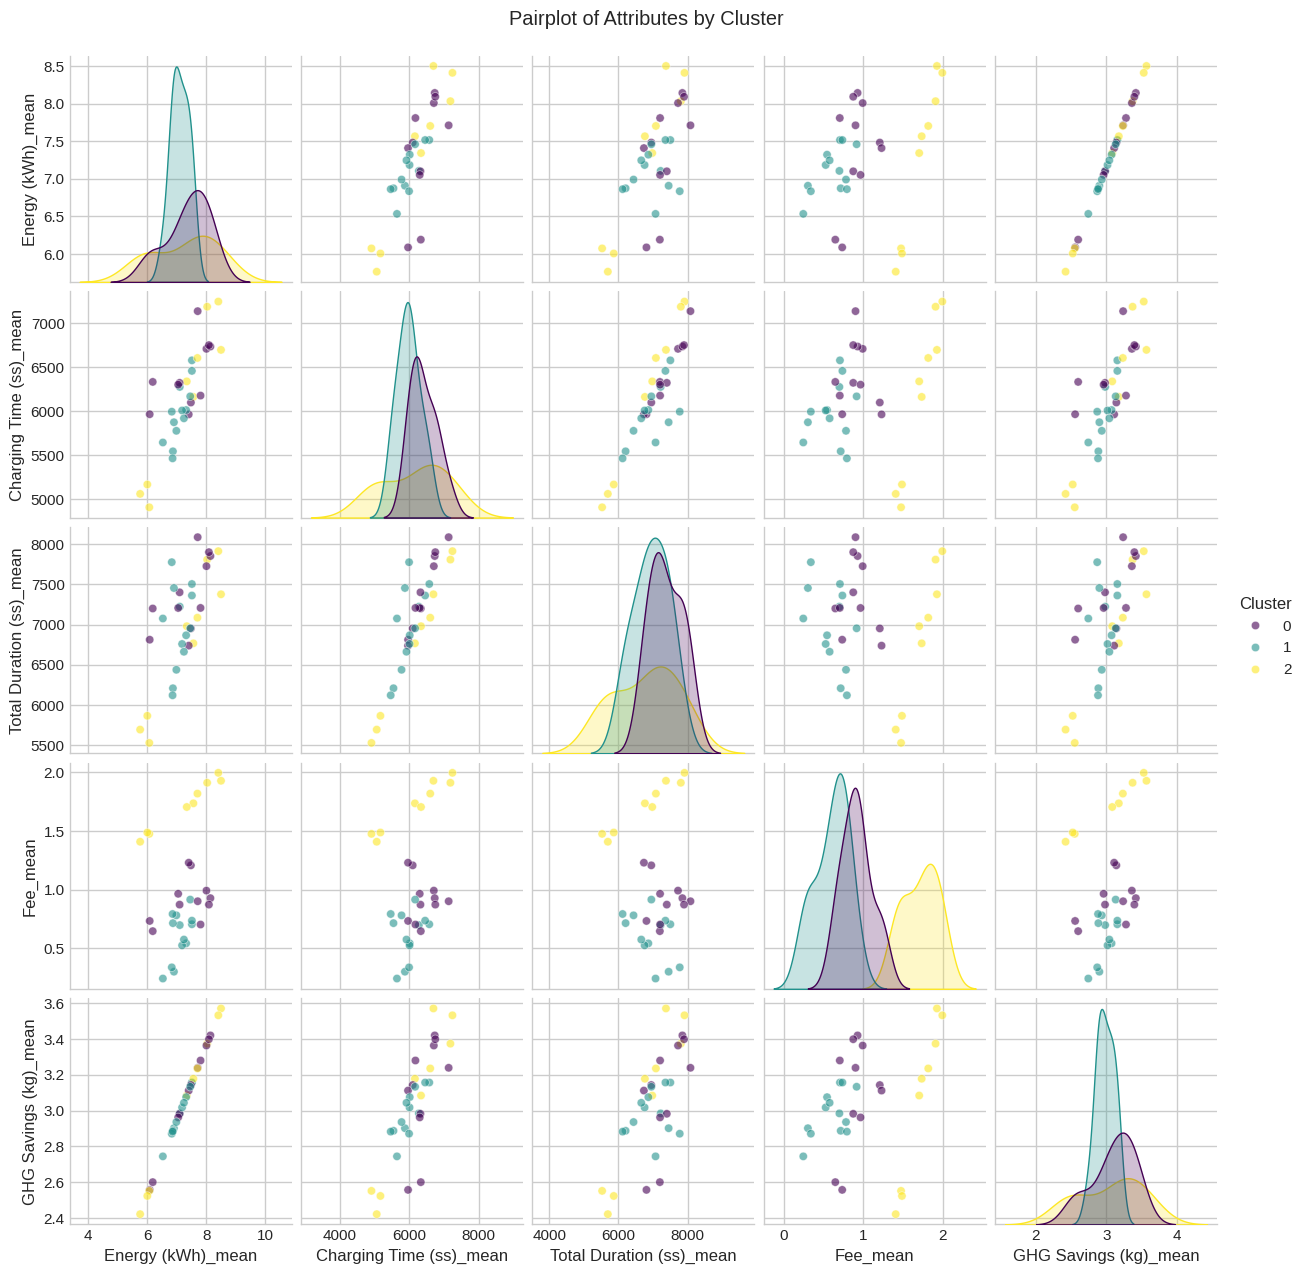

<Figure size 640x480 with 0 Axes>

In [ ]:
# Pairplot for Multiple Attributes (using available '_mean' columns)
pairplot_attributes = ['Energy (kWh)_mean', 'Charging Time (ss)_mean', 'Total Duration (ss)_mean', 'Fee_mean', 'GHG Savings (kg)_mean']
sns.pairplot(aggregated_data, vars=pairplot_attributes, hue='Cluster', palette='viridis', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Attributes by Cluster', y=1.02)
plt.show()

plt.tight_layout()
plt.show()



- **Cluster A:** High energy usage, longer charging times, and extended total durations. Likely drivers with larger batteries or starting from a low state of charge. Significant GHG savings, but potentially higher fees.

- **Cluster B:** Moderate energy and time metrics. Represents an “average” user segment—balanced fees and GHG savings, reflecting a stable core customer base.

- **Cluster C:** Lower energy per session, shorter durations, yet potentially higher relative fees. Suggests brief top-up charging behavior at premium rates, with reduced GHG savings.

**Recommendations:**

1. **Pricing Optimization:**
   - Introduce tiered or time-based pricing to align costs with usage patterns.
   - Offer off-peak discounts or loyalty incentives to encourage efficient charging behaviors, benefiting Clusters A and B.

2. **Infrastructure Planning:**
   - Install additional fast chargers in areas used heavily by Cluster A to reduce congestion and improve user experience.
   - Maintain sufficient standard chargers for consistent Cluster B usage patterns.

3. **Customer Engagement:**
   - Educate Cluster C users on optimal charging times and strategies to reduce fees and increase their environmental impact.
   - Provide targeted communication and rewards that encourage longer, more efficient sessions across all clusters.




# **Mandatory Component: Time Series Prediction Model**

## Preprocessing
0. **Data cleaning:** Exclude data< 2018-02 due to high error rates.
1. **Hourly Expansion:** Split each charging session into hourly chunks, calculating proportional energy usage.
2. **Group stations:** Cluster based on energy consumption behavior.
3. **Handle duplicates:** Resolve duplicates per hour by averaging energy values.  
4. **Consistent granularity:** Fill missing hours with 0 energy, creating a complete time-station grid.

In [ ]:
dataTS = new_df[['Station Name','Start Date', 'Charging Time (hh:mm:ss)','Energy (kWh)']]

# 0. **Data cleaning:** Exclude data prior to 2018-03 due to high error rates.
dataTS = dataTS[dataTS['Start Date'] > '2018-02-01']


dfTS = pd.DataFrame(dataTS)

# Convert `Start Date` and `Charging Time` to datetime and timedelta
dfTS["Start Date"] = pd.to_datetime(dfTS["Start Date"])
dfTS["Charging Time"] = pd.to_timedelta(dfTS["Charging Time (hh:mm:ss)"])
dfTS["End Date"] = dfTS["Start Date"] + dfTS["Charging Time"]


# 1. Hourly Expansion: Split each charging session into hourly chunks, calculating proportional energy usage.
rows = []

for _, row in dfTS.iterrows():
    #print(row)
    start = row["Start Date"]
    end = row["End Date"]
    station = row["Station Name"]
    total_energy = row["Energy (kWh)"]

    # Calculate energy per hour
    current = start
    while current < end:
        next_hour = (current + pd.Timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
        if next_hour > end:
            next_hour = end
        duration = (next_hour - current).total_seconds() / 3600
        energy = total_energy * (duration / row["Charging Time"].total_seconds() * 3600)  # Energia proporzionale

        rows.append({
            "Time": current.replace(minute=0, second=0, microsecond=0),
            "Energy (kWh)": energy,
            "Station Name": station,
        })

        current = next_hour

# resulting dataframe
expanded_df = pd.DataFrame(rows)

To develop accurate predictive models for energy consumption, **clustering was performed on stations based on consumption behavior similarity.** These clusters enable the creation of specific models for similar stations, leveraging more data for improved optimization and prediction.

***Choose the cluster you want to visualize analysis and prediction models.***

In [ ]:
# 2. Group stations: Cluster based on energy consumption behavior.
# Define the mapping for clusters to let the user understand better how STATION ARE MAPPED
cluster_labels = {
    0: "Cluster A",
    1: "Cluster B",
    2: "Cluster C"
}

aggregated_data['Cluster Label'] = aggregated_data['Cluster'].map(cluster_labels)
print(aggregated_data[["Station Name", "Cluster Label"]])

                      Station Name Cluster Label
0         PALO ALTO CA / BRYANT #1     Cluster B
1         PALO ALTO CA / BRYANT #2     Cluster B
2         PALO ALTO CA / BRYANT #3     Cluster B
3         PALO ALTO CA / BRYANT #4     Cluster C
4         PALO ALTO CA / BRYANT #5     Cluster C
5         PALO ALTO CA / BRYANT #6     Cluster C
6      PALO ALTO CA / CAMBRIDGE #1     Cluster A
7      PALO ALTO CA / CAMBRIDGE #2     Cluster A
8      PALO ALTO CA / CAMBRIDGE #3     Cluster C
9      PALO ALTO CA / CAMBRIDGE #4     Cluster C
10     PALO ALTO CA / CAMBRIDGE #5     Cluster C
11      PALO ALTO CA / HAMILTON #1     Cluster A
12      PALO ALTO CA / HAMILTON #2     Cluster A
13          PALO ALTO CA / HIGH #1     Cluster A
14          PALO ALTO CA / HIGH #2     Cluster A
15          PALO ALTO CA / HIGH #3     Cluster A
16          PALO ALTO CA / HIGH #4     Cluster B
17           PALO ALTO CA / MPL #1     Cluster B
18           PALO ALTO CA / MPL #2     Cluster B
19           PALO AL

In [ ]:
# IMPORTANT!
#We SELECTED AND EXECUTED THE CODE WITH CLUSTER A due to its highest energy consumption frequency, ensuring more data for better models and pattern identification.



# Cluster A: High energy usage, longer charging times, and extended total durations. Likely drivers with larger batteries or starting from a low state of charge. Significant GHG savings, but potentially higher fees.
clusterA = expanded_df[
    (expanded_df['Station Name'].isin([
    'PALO ALTO CA / CAMBRIDGE #1',
    'PALO ALTO CA / CAMBRIDGE #2',
    'PALO ALTO CA / HAMILTON #1',
    'PALO ALTO CA / HAMILTON #2',
    'PALO ALTO CA / HIGH #1',
    'PALO ALTO CA / HIGH #2',
    'PALO ALTO CA / HIGH #3',
    'PALO ALTO CA / TED THOMPSON #1',
    'PALO ALTO CA / WEBSTER #1',
    'PALO ALTO CA / WEBSTER #2',
    'PALO ALTO CA / WEBSTER #3'
    ]))
]

# Cluster B: Moderate energy and time metrics. Represents an “average” user segment—balanced fees and GHG savings, reflecting a stable core customer base.
clusterB = expanded_df[
    (expanded_df['Station Name'].isin([
    'PALO ALTO CA / BRYANT #1',
    'PALO ALTO CA / BRYANT #2',
    'PALO ALTO CA / BRYANT #3',
    'PALO ALTO CA / HIGH #4',
    'PALO ALTO CA / MPL #1',
    'PALO ALTO CA / MPL #2',
    'PALO ALTO CA / MPL #3',
    'PALO ALTO CA / MPL #4',
    'PALO ALTO CA / MPL #5',
    'PALO ALTO CA / MPL #6',
    'PALO ALTO CA / RINCONADA LIB 1',
    'PALO ALTO CA / RINCONADA LIB 2',
    'PALO ALTO CA / RINCONADA LIB 3'
    ]))
]

# Cluster C: Lower energy per session, shorter durations, yet potentially higher relative fees. Suggests brief top-up charging behavior at premium rates, with reduced GHG savings.
clusterC = expanded_df[
    (expanded_df['Station Name'].isin([
    'PALO ALTO CA / BRYANT #4',
    'PALO ALTO CA / BRYANT #5',
    'PALO ALTO CA / BRYANT #6',
    'PALO ALTO CA / CAMBRIDGE #3',
    'PALO ALTO CA / CAMBRIDGE #4',
    'PALO ALTO CA / CAMBRIDGE #5',
    'PALO ALTO CA / TED THOMPSON #2',
    'PALO ALTO CA / TED THOMPSON #3',
    'PALO ALTO CA / TED THOMPSON #4'
    ]))
]


# Dictionary to map cluster names to DataFrames
clusters = {
    'A': clusterA,
    'B': clusterB,
    'C': clusterC
}

# Ask the user to choose a cluster
print("\nChoose the desired cluster:")
print("A: High energy consumption")
print("B: Moderate energy consumption")
print("C: Low energy consumption")

selected_cluster = input("\nEnter the cluster number: ")
print("\n")

# Check if the selected cluster number exists in the dictionary
if selected_cluster in clusters:
    cluster_data = clusters[selected_cluster]

    # Group by Time and Station Name to calculate sum of energy
    dfTS1 = cluster_data.groupby(['Time', 'Station Name'])['Energy (kWh)'].sum().reset_index()
    print(dfTS1)
else:
    print("Invalid cluster selection.")



Choose the desired cluster:
1: High energy consumption
2: Moderate energy consumption
3: Low energy consumption

Enter the cluster number: 1


                     Time                 Station Name  Energy (kWh)
0     2018-02-01 05:00:00  PALO ALTO CA / CAMBRIDGE #2      2.211917
1     2018-02-01 06:00:00  PALO ALTO CA / CAMBRIDGE #2      3.144083
2     2018-02-01 06:00:00   PALO ALTO CA / HAMILTON #2      5.539949
3     2018-02-01 07:00:00  PALO ALTO CA / CAMBRIDGE #2      2.334694
4     2018-02-01 07:00:00   PALO ALTO CA / HAMILTON #1      3.470921
...                   ...                          ...           ...
73599 2019-12-31 20:00:00   PALO ALTO CA / HAMILTON #1      2.975333
73600 2019-12-31 20:00:00       PALO ALTO CA / HIGH #3      5.866143
73601 2019-12-31 20:00:00    PALO ALTO CA / WEBSTER #1      3.057018
73602 2019-12-31 21:00:00       PALO ALTO CA / HIGH #3      1.179857
73603 2019-12-31 21:00:00    PALO ALTO CA / WEBSTER #1      1.126033

[73604 rows x 3 columns]


In [ ]:
def preprocess_time_series(df):
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values('Time')
    #print(df)

    # 3. Handle duplicates: Resolve duplicates per hour by averaging energy values.
    averaged_data = df.groupby('Time')['Energy (kWh)'].mean().reset_index()

    # Create a complete time range with hourly frequency
    start_time = averaged_data['Time'].min()
    end_time = averaged_data['Time'].max()
    full_time_range = pd.date_range(start=start_time, end=end_time, freq='h')

    # 4. Consistent granularity: Fill missing hours with 0 energy, creating a complete time-station grid.
    full_df = pd.DataFrame({'Time': full_time_range})
    result = full_df.merge(averaged_data, on='Time', how='left').fillna({'Energy (kWh)': 0})

    result = result.sort_values('Time')

    # changes
    original_count = len(df)
    new_count = len(result)
    missing_hours = new_count - len(averaged_data)

    print(f"Original data points: {original_count}")
    print(f"Averaged data points (before filling): {len(averaged_data)}")
    print(f"New data points (after filling): {new_count}")
    print(f"Missing hours added: {missing_hours}")

    return result

cleaned_df1 = preprocess_time_series(dfTS1)

print("\n\n COMPLETE TIME SERIE FOR CLUSTER",selected_cluster,": \n")
print(cleaned_df1)


Original data points: 73604
Averaged data points (before filling): 12716
New data points (after filling): 16769
Missing hours added: 4053


 COMPLETE TIME SERIE FOR CLUSTER 1 : 

                     Time  Energy (kWh)
0     2018-02-01 05:00:00      2.211917
1     2018-02-01 06:00:00      4.342016
2     2018-02-01 07:00:00      3.916695
3     2018-02-01 08:00:00      3.438598
4     2018-02-01 09:00:00      4.636268
...                   ...           ...
16764 2019-12-31 17:00:00      3.138821
16765 2019-12-31 18:00:00      2.687015
16766 2019-12-31 19:00:00      3.209163
16767 2019-12-31 20:00:00      3.966165
16768 2019-12-31 21:00:00      1.152945

[16769 rows x 2 columns]


## Visualization  
To understand the behavior of our time series, we first need to visualize it.

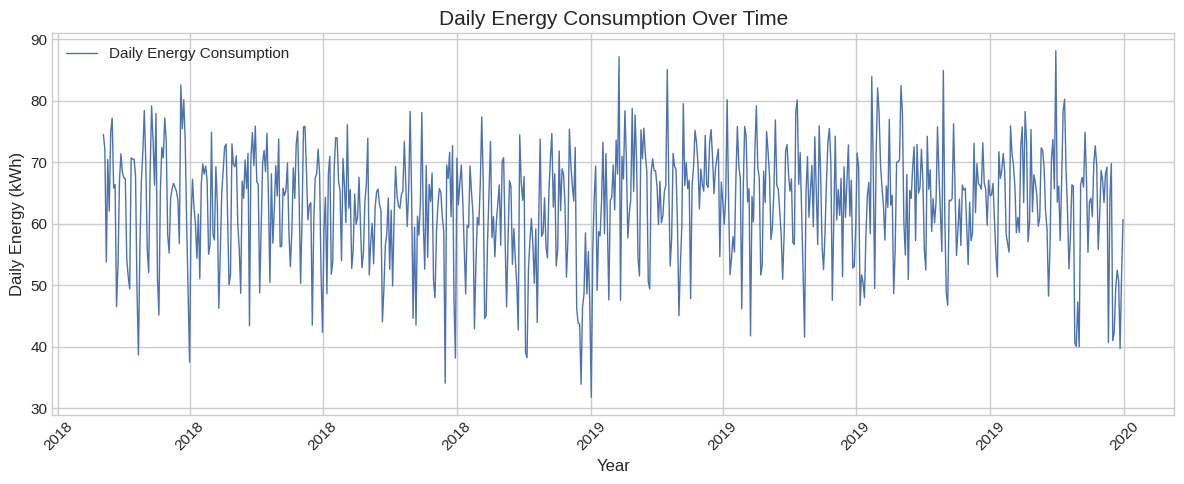

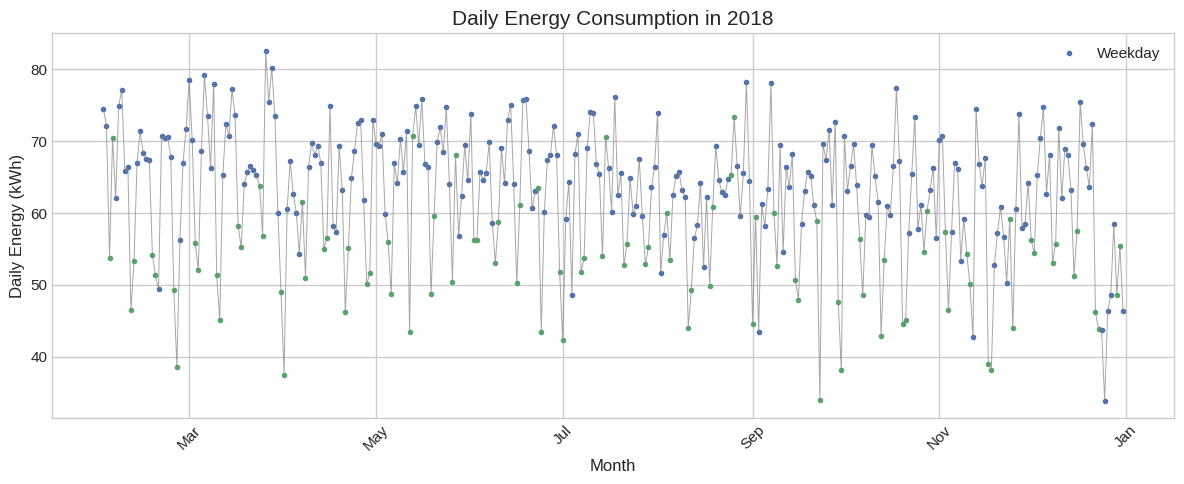

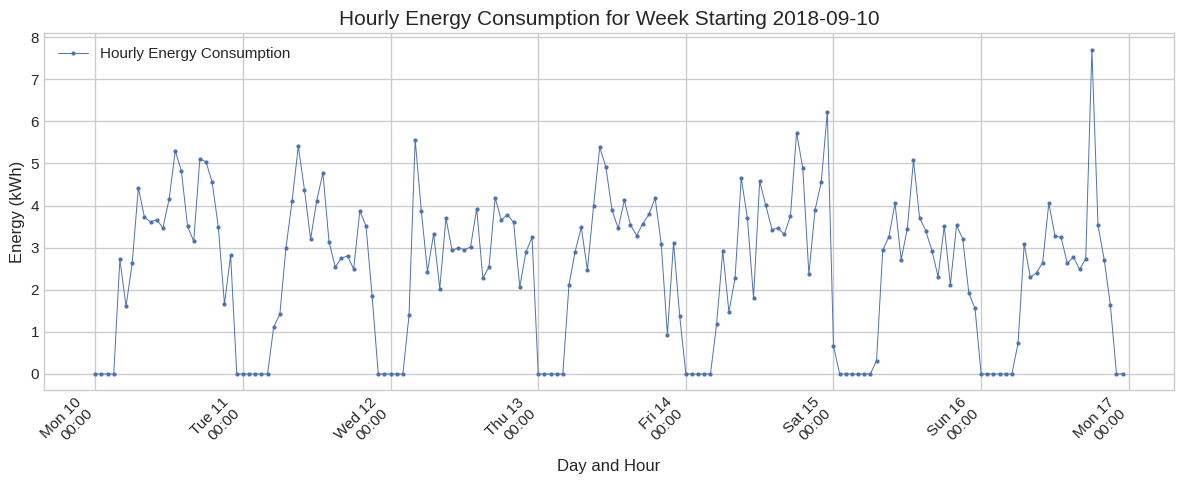

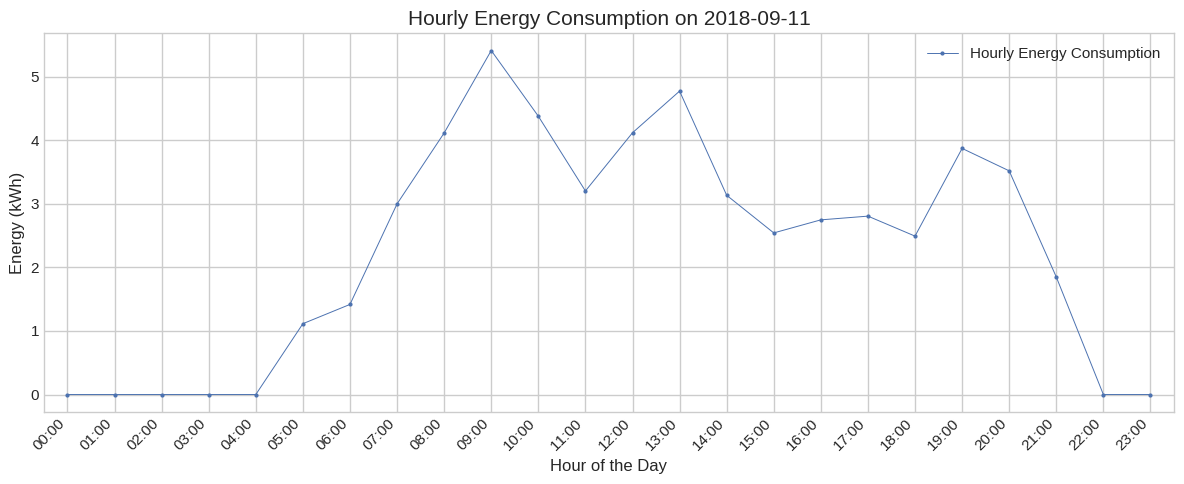

In [ ]:
cleaned_df = cleaned_df1.copy()
# Convert 'Time' to datetime
cleaned_df["Time"] = pd.to_datetime(cleaned_df["Time"])

# Daily energy consumption over time
daily_energy = cleaned_df.groupby(cleaned_df["Time"].dt.date)["Energy (kWh)"].sum().reset_index()
daily_energy["Time"] = pd.to_datetime(daily_energy["Time"])

plt.figure(figsize=(12, 5))
plt.plot(daily_energy["Time"], daily_energy["Energy (kWh)"], linewidth=1, linestyle='-', label="Daily Energy Consumption")
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().margins(x=0.05)
plt.title("Daily Energy Consumption Over Time", fontsize=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Daily Energy (kWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n")

# Daily energy consumption for 2018
df_2018 = cleaned_df[cleaned_df["Time"].dt.year == 2018].groupby(cleaned_df["Time"].dt.date)["Energy (kWh)"].sum().reset_index()
df_2018["Time"] = pd.to_datetime(df_2018["Time"])
df_2018["Weekend"] = df_2018["Time"].dt.dayofweek >= 5

plt.figure(figsize=(12, 5))
for idx, row in df_2018.iterrows():
    plt.plot(row["Time"], row["Energy (kWh)"], 'go' if row["Weekend"] else 'bo',
             markersize=3, label="Weekend" if row["Weekend"] and idx == 0 else ("Weekday" if not row["Weekend"] and idx == 0 else ""))
plt.plot(df_2018["Time"], df_2018["Energy (kWh)"], linewidth=0.7, linestyle='-', color='gray', alpha=0.7)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
plt.gca().margins(x=0.05)
plt.title("Daily Energy Consumption in 2018", fontsize=15)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Daily Energy (kWh)", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
print("\n")

# Hourly energy consumption for a specific week
start_date = '2018-09-10'
end_date = pd.to_datetime(start_date) + pd.Timedelta(days=7)
weekly_data = cleaned_df[(cleaned_df["Time"] >= start_date) & (cleaned_df["Time"] < end_date)]
plt.figure(figsize=(12, 5))
plt.plot(weekly_data["Time"], weekly_data["Energy (kWh)"], linewidth=0.7, marker='o', linestyle='-', markersize=2, label="Hourly Energy Consumption")
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%a %d\n%H:%M'))
plt.gca().margins(x=0.05)
plt.title(f"Hourly Energy Consumption for Week Starting {start_date}", fontsize=15)
plt.xlabel("Day and Hour", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("\n")

# Hourly energy consumption for a specific day
selected_date = '2018-09-11'
daily_data = cleaned_df[cleaned_df["Time"].dt.date == pd.to_datetime(selected_date).date()]

plt.figure(figsize=(12, 5))
plt.plot(daily_data["Time"].dt.hour, daily_data["Energy (kWh)"], linewidth=0.7, marker='o', linestyle='-', markersize=2, label="Hourly Energy Consumption")
plt.title(f"Hourly Energy Consumption on {selected_date}", fontsize=15)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Energy (kWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(range(24), [f'{hour:02d}:00' for hour in range(24)], rotation=45, ha='right')
plt.xlim(-0.5, 23.5)
plt.tight_layout()
plt.show()


## Analysis

### Stationarity Test  
**OUTPUT: Not stationary**  

**Summary Statistics:**  
Splitting the data shows slight changes in mean and variance, likely non-stationarity.

In [ ]:
cleaned_df1.set_index('Time', inplace=True)
cleaned_df1.sort_index(inplace=True)

# Split the dataset into two halves
split_index = len(cleaned_df1) // 2
first_half = cleaned_df1["Energy (kWh)"].iloc[:split_index]
second_half = cleaned_df1["Energy (kWh)"].iloc[split_index:]

# Compute means and variances
print("First Half Mean:", first_half.mean(), "Variance:", first_half.var())
print("Second Half Mean:", second_half.mean(), "Variance:", second_half.var())

First Half Mean: 2.574676239462048 Variance: 3.2053146105362167
Second Half Mean: 2.6815425209317696 Variance: 3.5933846361270514


We chose the **KPSS test** over ADF, as ADF can misidentify non-stationary series (**Appendix A.2**).  
**KPSS Test:**  
- **H₀:** Series is stationary.  
- **H₁:** Series is not stationary.  

In [ ]:
# Perform the KPSS test
result = kpss(cleaned_df1["Energy (kWh)"])
print("KPSS Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[3].items():
    print(f"    {key}: {value:.3f}")

# Interpretation
if result[1] <= 0.05:
    print("The series is not stationary (reject H₀).")
else:
    print("The series is stationary (fail to reject H₀).")


KPSS Statistic: 0.13807159669506894
p-value: 0.1
Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is stationary (fail to reject H₀).


<ipython-input-66-d24ccab97314>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(cleaned_df1["Energy (kWh)"])


One differencing ensures stationarity, verified by KPSS.


KPSS Test Statistic: 0.010567329358964974
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

The series is likely stationary (p-value >= 0.05).



<ipython-input-67-29a548dba28f>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kwargs)


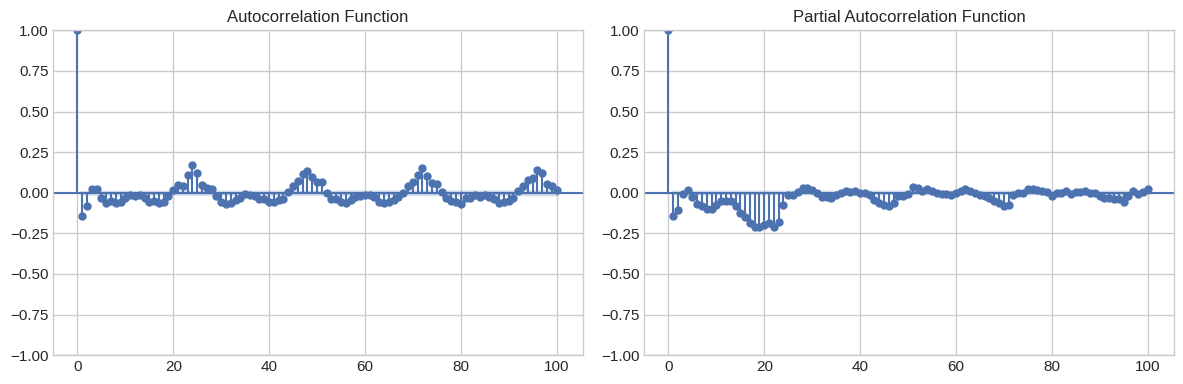

In [ ]:
# Perform first differencing
df_diff = cleaned_df1.diff(1).dropna()

# KPSS test to check stationarity
def kpss_test(series, **kwargs):
    statistic, p_value, n_lags, critical_values = kpss(series, **kwargs)
    print("\nKPSS Test Statistic:", statistic)
    print("p-value:", p_value)
    #print("Number of Lags:", n_lags)
    print("Critical Values:", critical_values)

    # Interpretation
    if p_value < 0.05:
        print("\nThe series is likely non-stationary (p-value < 0.05).\n")
    else:
        print("\nThe series is likely stationary (p-value >= 0.05).\n")
        # ACF and PACF Plots
        plt.figure(figsize=(12,4))

        plt.subplot(121)
        plot_acf(df_diff['Energy (kWh)'], lags=100, ax=plt.gca())
        plt.title('Autocorrelation Function')

        plt.subplot(122)
        plot_pacf(df_diff['Energy (kWh)'], lags=100, ax=plt.gca())
        plt.title('Partial Autocorrelation Function')

        plt.tight_layout()
        plt.show()

# Run KPSS test on the differenced series
kpss_test(df_diff["Energy (kWh)"])

### Seasonality Analysis  
**OUTPUT: Seasonality present**  

**Time Series Decomposition:**  
- **Trend:** Slight decline in energy use (2017-2018), rising in 2019, and stabilizing.  
- **Seasonality:** Regular daily consumption patterns.  
- **Residuals:** Stationary.


Decomposing Time Series Daily:


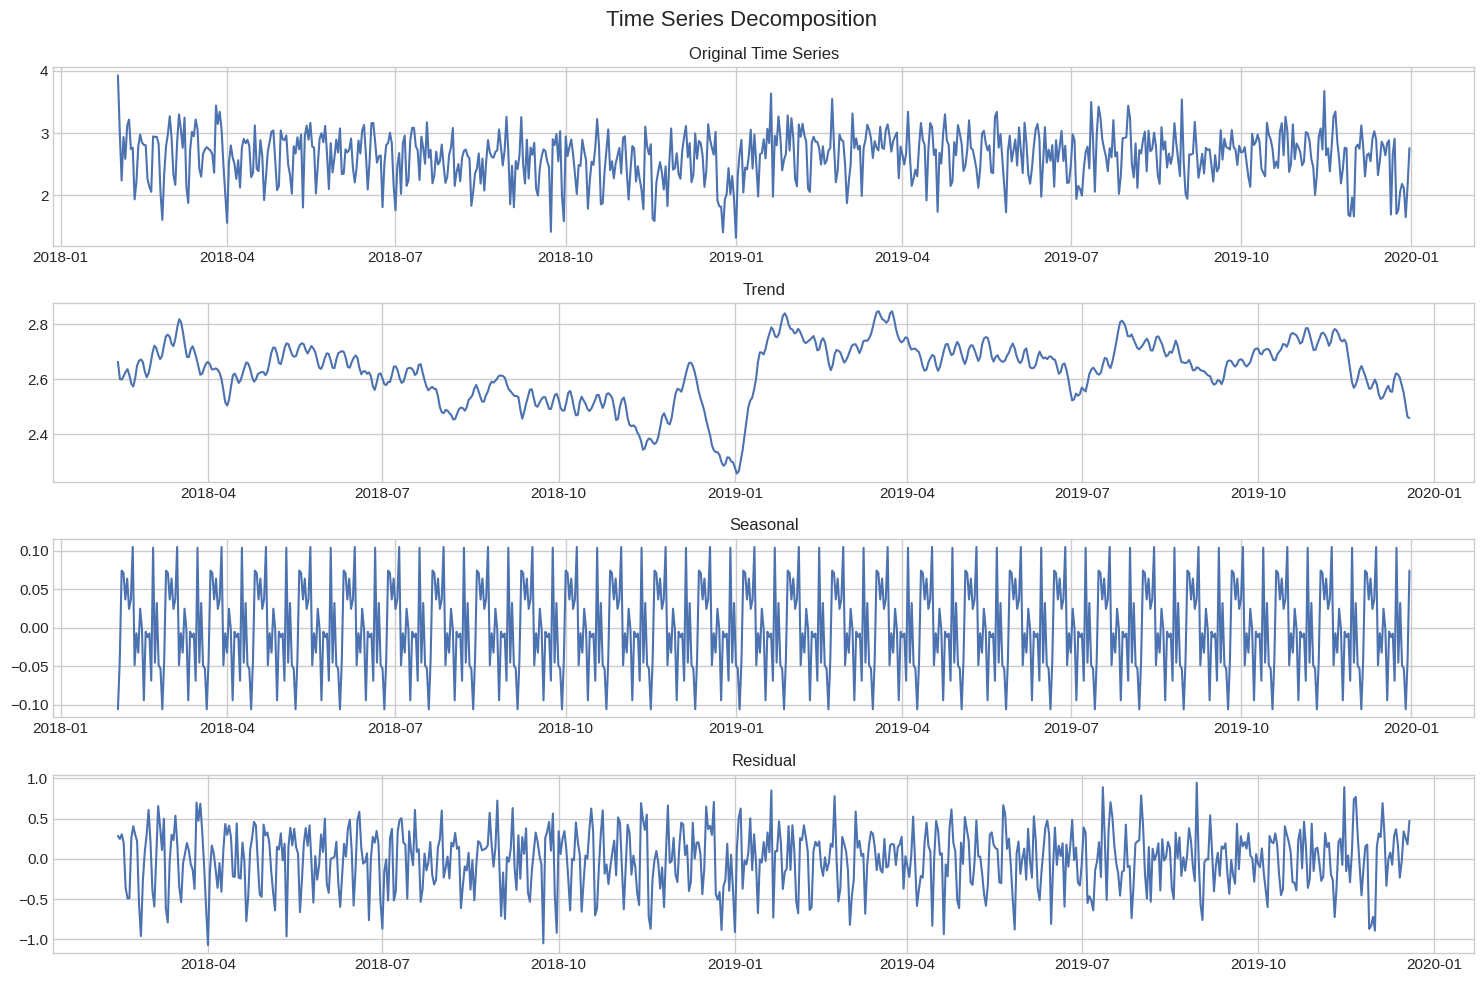



Executing ADF Test on Residuals:
ADF Statistic: -10.083125839910746
p-value: 1.1742505608119801e-17
Residuals are stationary; decomposition likely correct.


In [ ]:
def decompose_timeseries(ts_data,period):
    # Resample to daily data for decomposition
    daily_data = ts_data.resample('D').mean()

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(daily_data, period=period)  # Assuming annual seasonality

    # Plot decomposition
    plt.figure(figsize=(15,10))
    plt.suptitle('Time Series Decomposition', fontsize=16)

    plt.subplot(411)
    plt.title('Original Time Series')
    plt.plot(daily_data)

    plt.subplot(412)
    plt.title('Trend')
    plt.plot(decomposition.trend)

    plt.subplot(413)
    plt.title('Seasonal')
    plt.plot(decomposition.seasonal)

    plt.subplot(414)
    plt.title('Residual')
    plt.plot(decomposition.resid)

    plt.tight_layout()
    plt.show()


    # ADF Test on Residuals

    print("\n\nExecuting ADF Test on Residuals:")
    adf_test = adfuller(decomposition.resid.dropna())
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")

    # Interpretation
    if adf_test[1] < 0.05:
      print("Residuals are stationary; decomposition likely correct.")
    else:
      print("Residuals are not stationary; check seasonal period or model assumptions.")


print("\nDecomposing Time Series Daily:")
decompose_timeseries(cleaned_df1['Energy (kWh)'],24)

**Seasonality**  
1. **Hourly:** Low consumption at night (01:00–04:00), peaks during the day, drops at night (23:00–00:00).  

2. **Weekly:** Weekdays average 2.636 kWh, weekends 2.1 kWh, a 20.33% drop. (Appendix A.3)

3. **Annual:** Stable consumption with no clear seasonal trends.

<ipython-input-69-b0efb94b777c>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_means = df_advanced.groupby('Weekday Name')['Energy (kWh)'].mean()
<ipython-input-69-b0efb94b777c>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_means = df_advanced.groupby('Month')['Energy (kWh)'].mean()
<ipython-input-69-b0efb94b777c>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_advanced, x='Hour', y='Energy (kWh)', palette='viridis')


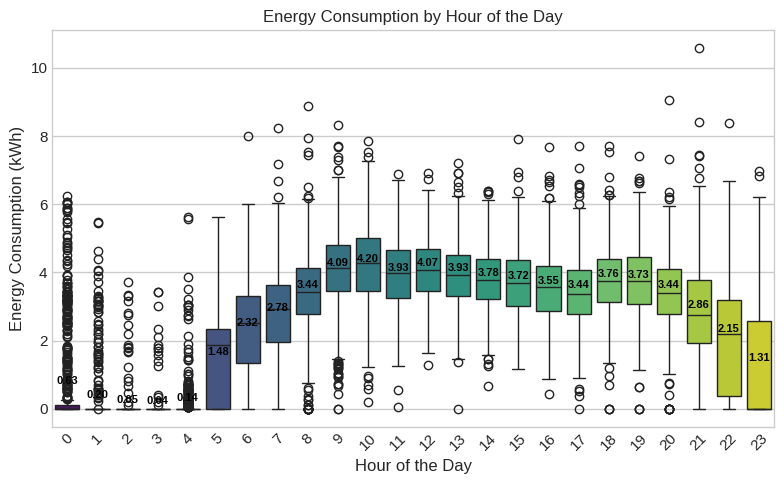

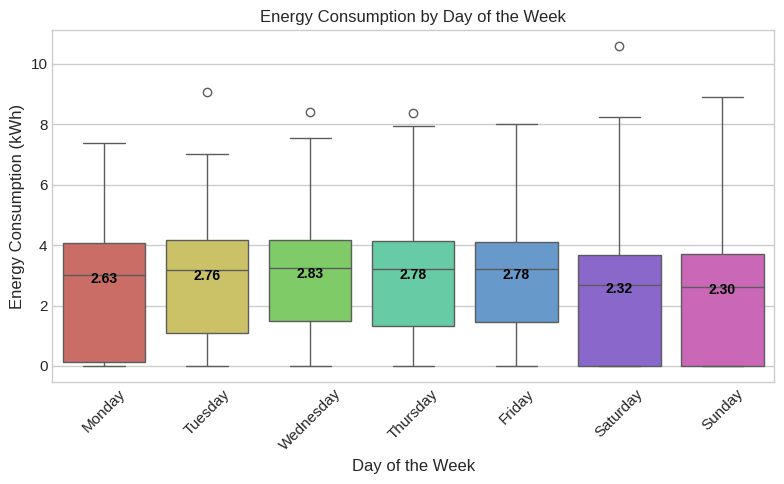

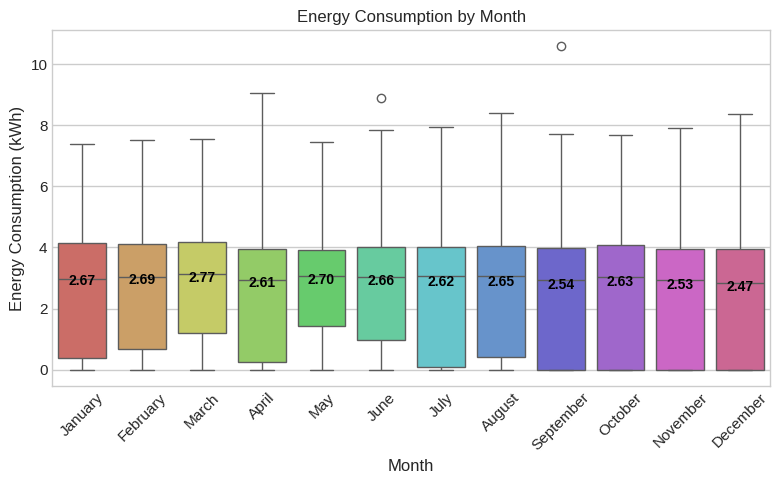

In [ ]:
df_advanced = cleaned_df1.copy()

df_advanced.index = pd.to_datetime(df_advanced.index)

# Extract index info
df_advanced['Hour'] = df_advanced.index.hour
df_advanced['Weekday Name'] = df_advanced.index.day_name()
df_advanced['Month'] = df_advanced.index.month_name()

# order for weekdays and months
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# categorical type for weekdays and months
df_advanced['Weekday Name'] = pd.Categorical(df_advanced['Weekday Name'], categories=weekday_order, ordered=True)
df_advanced['Month'] = pd.Categorical(df_advanced['Month'], categories=month_order, ordered=True)

# Calculate mean energy for each weekday, month and hour of day
weekday_means = df_advanced.groupby('Weekday Name')['Energy (kWh)'].mean()
month_means = df_advanced.groupby('Month')['Energy (kWh)'].mean()
hourly_means = df_advanced.groupby('Hour')['Energy (kWh)'].mean()

# Create the boxplot for hours of the day
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_advanced, x='Hour', y='Energy (kWh)', palette='viridis')
for hour in range(24):
    plt.text(hour, hourly_means[hour] + 0.1, f'{hourly_means[hour]:.2f}',
             horizontalalignment='center', size=8, color='black', weight='semibold')
plt.title("Energy Consumption by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Create the boxplot for weekdays
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_advanced, x='Weekday Name', y='Energy (kWh)', hue='Weekday Name', palette=sns.color_palette("hls", 7), legend=False)
for i, weekday in enumerate(weekday_order):
    plt.text(i, weekday_means[weekday] + 0.1, f'{weekday_means[weekday]:.2f}', horizontalalignment='center', size=10, color='black', weight='semibold')
plt.title("Energy Consumption by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Create the boxplot for months
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_advanced, x='Month', y='Energy (kWh)', hue='Month', palette=sns.color_palette("hls", 12), legend=False)
for i, month in enumerate(month_order):
    plt.text(i, month_means[month] + 0.1, f'{month_means[month]:.2f}', horizontalalignment='center', size=10, color='black', weight='semibold')
plt.title("Energy Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Fourier Transform   
We confirm 24-hour seasonality with a clear x-axis peak at 1/24 (=0.042).

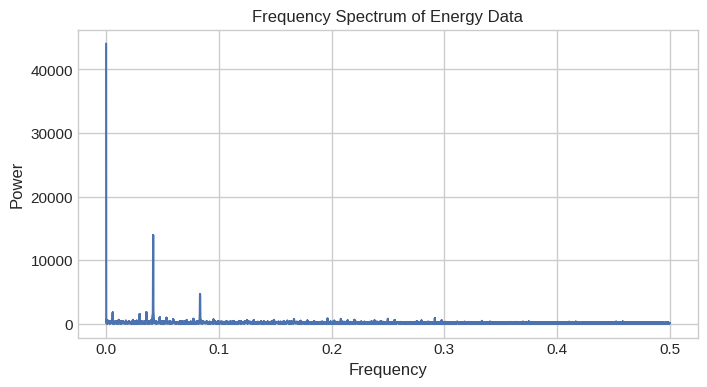

In [ ]:
# transform in numerical values so i can apply FFT
energy_values = cleaned_df1['Energy (kWh)'].dropna().values

# Apply Fourier Transform
fft_vals = fft(energy_values)
fft_freqs = np.fft.fftfreq(len(fft_vals), d=1) # corresponding frequencies

# frequency spectrum
plt.figure(figsize=(8, 4))
plt.plot(np.abs(fft_freqs), np.abs(fft_vals))
plt.title("Frequency Spectrum of Energy Data")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.show()


### AC and PAC

**ACF:** Significant peaks at regular lags, indicating strong seasonality, likely related to the time of day.  

**PACF:** Significant spike at lag 1, suggesting an AR(1) process for the model.

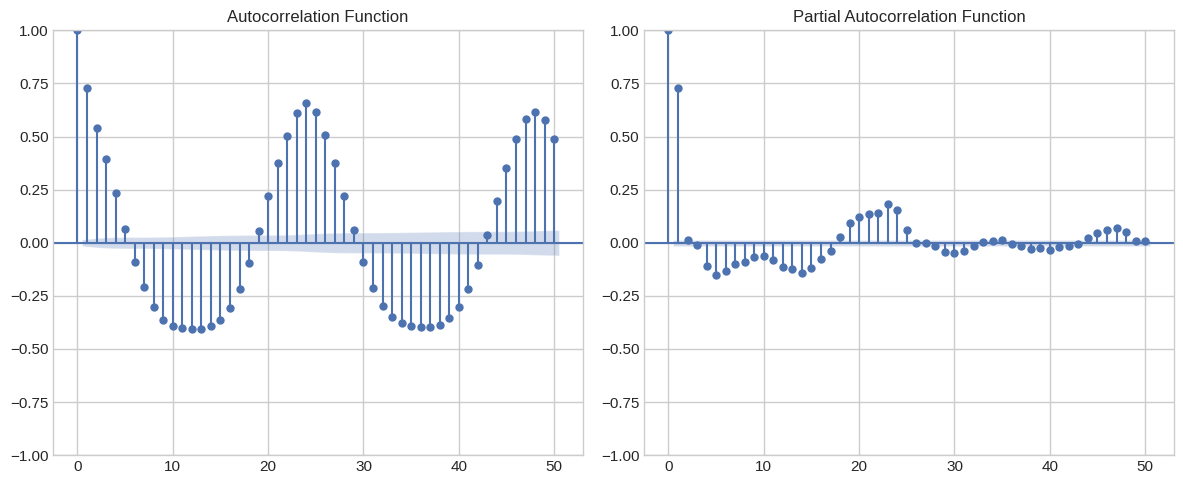

In [ ]:
# ACF and PACF Plots
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_acf(cleaned_df1['Energy (kWh)'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(cleaned_df1['Energy (kWh)'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

## Prediction Models
**After analyzing all clusters and creating specific models, we found Sarmix had uniform parameters. Key differences involved frequency and charging values at stations. Running the code for each cluster mitigates these differences, as training focuses on stations with similar energy use. This ensures tailored models, optimizing training and improving predictions by removing inter-cluster discrepancies.**

In [ ]:
df_prediction=cleaned_df1[['Energy (kWh)']]
train_size = int(0.7 * len(df_prediction))

### Naïve Baseline  
Predict next day's hourly consumption using historical weekday averages.

In [ ]:
df_prediction = df_prediction.reset_index()
df_prediction['Hour'] = df_prediction['Time'].dt.hour
df_prediction['Day_of_Week'] = df_prediction['Time'].dt.dayofweek

# Split the data into training and testing sets !!
train_data = df_prediction[:train_size]
test_data = df_prediction[train_size:]
#print(train_data)
#print(test_data)

# Predict the energy consumption using the historical averages
historical_avg = train_data.groupby(['Day_of_Week', 'Hour'])['Energy (kWh)'].mean().reset_index()
historical_avg.rename(columns={'Energy (kWh)': 'Historical_Avg'}, inplace=True)
test_data = test_data.merge(historical_avg, on=['Day_of_Week', 'Hour'], how='left')
test_data['Prediction'] = test_data['Historical_Avg']


# Calculate accuracy metrics
r2 = r2_score(test_data["Energy (kWh)"], test_data["Prediction"])
mae = mean_absolute_error(test_data["Energy (kWh)"], test_data["Prediction"])
mape = np.mean(np.abs((test_data["Energy (kWh)"] - test_data["Prediction"]) / test_data["Energy (kWh)"])) * 100

# Print the results
print(f"Test set with predictions:\n{test_data[['Time', 'Energy (kWh)', 'Prediction']]}\n")

print("\nAccuracy Metrics:")
print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Test set with predictions:
                    Time  Energy (kWh)  Prediction
0    2019-06-05 07:00:00      3.896011    3.150348
1    2019-06-05 08:00:00      3.763789    3.673001
2    2019-06-05 09:00:00      3.309672    4.399080
3    2019-06-05 10:00:00      4.516953    4.552489
4    2019-06-05 11:00:00      4.197900    4.122669
...                  ...           ...         ...
5026 2019-12-31 17:00:00      3.138821    3.388536
5027 2019-12-31 18:00:00      2.687015    3.776175
5028 2019-12-31 19:00:00      3.209163    3.506460
5029 2019-12-31 20:00:00      3.966165    3.346527
5030 2019-12-31 21:00:00      1.152945    2.784062

[5031 rows x 3 columns]


Accuracy Metrics:
R2 Score: 0.66
Mean Absolute Error (MAE): 0.79
Mean Absolute Percentage Error (MAPE): inf%


**Plot Prediction:**  
- Test period: Daily average prediction  
- One week: Hourly prediction

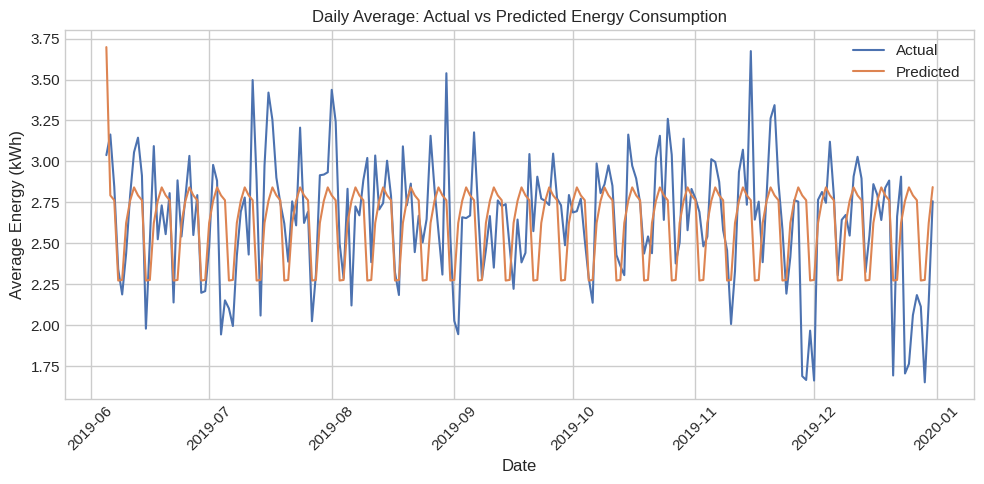

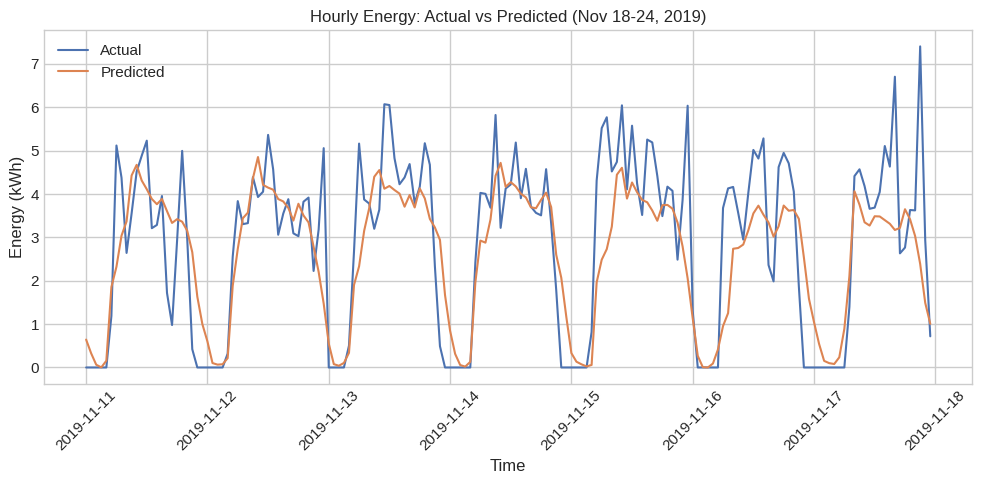

In [ ]:
    df=test_data.copy()
    df['Time'] = pd.to_datetime(df['Time'])

    # Daily aggregation
    daily_actual = df.groupby(df['Time'].dt.date)['Energy (kWh)'].mean()
    daily_predicted = df.groupby(df['Time'].dt.date)['Prediction'].mean()

    plt.figure(figsize=(10, 5))
    plt.plot(daily_actual.index, daily_actual.values, label='Actual')
    plt.plot(daily_predicted.index, daily_predicted.values, label='Predicted')
    plt.title('Daily Average: Actual vs Predicted Energy Consumption')
    plt.xlabel('Date')
    plt.ylabel('Average Energy (kWh)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Week from 18 to 24 November 2019
    week_filter = (df['Time'].dt.date >= pd.to_datetime('2019-11-11').date()) & \
                  (df['Time'].dt.date <= pd.to_datetime('2019-11-17').date())
    week_data = df[week_filter]

    plt.figure(figsize=(10, 5))
    plt.plot(week_data['Time'], week_data['Energy (kWh)'], label='Actual')
    plt.plot(week_data['Time'], week_data['Prediction'], label='Predicted')
    plt.title('Hourly Energy: Actual vs Predicted (Nov 18-24, 2019)')
    plt.xlabel('Time')
    plt.ylabel('Energy (kWh)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


### SARIMAX Model  
Use **SARIMAX** to predict consumption, handling both seasonality and overall trend.

                     Energy (kWh)  Hour  Day_of_Week  Is_Weekend
Time                                                            
2018-02-01 05:00:00      2.211917     5            3           0
2018-02-01 06:00:00      4.342016     6            3           0
2018-02-01 07:00:00      3.916695     7            3           0
2018-02-01 08:00:00      3.438598     8            3           0
2018-02-01 09:00:00      4.636268     9            3           0
...                           ...   ...          ...         ...
2019-12-31 17:00:00      3.138821    17            1           0
2019-12-31 18:00:00      2.687015    18            1           0
2019-12-31 19:00:00      3.209163    19            1           0
2019-12-31 20:00:00      3.966165    20            1           0
2019-12-31 21:00:00      1.152945    21            1           0

[16769 rows x 4 columns]





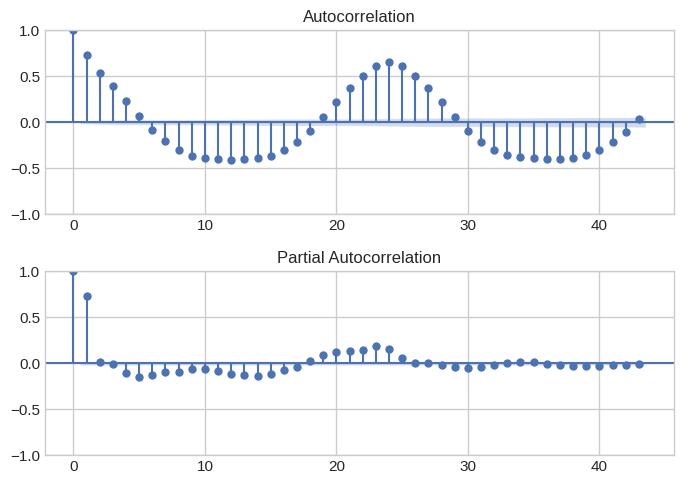

In [ ]:
df_prediction=cleaned_df1[[ 'Energy (kWh)']]
# Feature engineering
df_prediction['Hour'] = df_prediction.index.hour
df_prediction['Day_of_Week'] = df_prediction.index.dayofweek
df_prediction['Is_Weekend'] = df_prediction['Day_of_Week'].isin([5, 6]).astype(int)
print(df_prediction)

print("\n\n")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
plot_acf(df_prediction[["Energy (kWh)"]], ax=ax1)
plot_pacf(df_prediction[["Energy (kWh)"]], ax=ax2)
plt.tight_layout()
plt.show()

**Model Fitting**  

Analyze ACF, PACF, and seasonality to select parameters.  

**Parameter selection:**  
- **Seasonality:** \( m = 24 \) (lag 24).  
- **Differencing:** \( d = 1 \), \( D = 1 \).  
- **Non-Seasonal (\( p, q \)):**  
   - \( p = 1 \) (PACF).  
   - \( q = 1 \) or \( q = 2 \) (ACF).  
- **Seasonal (\( P, Q \)):**  
   - \( P = 1 \) or \( P = 0 \) (PACF).  
   - \( Q = 1 \) or \( Q = 2 \) (ACF).  
- **Exog variables:**  `Day_of_Week`, `Is_Weekend`.

**Model Trials:**  
- **SARIMA(1, 1, 1)(1, 1, 2, 24)**  
- SARIMA(2, 1, 1)(1, 1, 1, 24)  
- SARIMA(1, 1, 2)(0, 1, 2, 24) and more...


In [ ]:
# split train and test data
train_size = int(0.7 * len(df_prediction))
train_data = df_prediction[:train_size]
test_data = df_prediction[train_size:]

warnings.filterwarnings("ignore")

model = sm.tsa.SARIMAX(train_data['Energy (kWh)'],
                      exog=train_data[['Day_of_Week','Is_Weekend']],
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 2, 24),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results = model.fit()

print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                            Energy (kWh)   No. Observations:                11738
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 24)   Log Likelihood              -16778.105
Date:                                 Mon, 09 Dec 2024   AIC                          33572.210
Time:                                         18:54:04   BIC                          33631.124
Sample:                                     02-01-2018   HQIC                         33592.000
                                          - 06-05-2019                                         
Covariance Type:                                   opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Day_of_Week     0.0257      0.012      2.166      0.030       0.002     

**Evaluate Forecast**

In [ ]:
# Forecast
pred = results.get_forecast(len(test_data), exog=test_data[['Day_of_Week', 'Is_Weekend']])
test_pred = pred.predicted_mean

# Calculate accuracy metrics
r2 = r2_score(test_data["Energy (kWh)"], test_pred)
mae = mean_absolute_error(test_data["Energy (kWh)"], test_pred)
mape = np.mean(np.abs((test_data["Energy (kWh)"] - test_pred) / test_pred)) * 100

# Print the predictions
print("Predictions:")
print(test_pred)

# Metrics
print("\n\nAccuracy Metrics:")
print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Predictions:
2019-06-05 07:00:00    3.234105
2019-06-05 08:00:00    3.879016
2019-06-05 09:00:00    4.496914
2019-06-05 10:00:00    4.394285
2019-06-05 11:00:00    4.078317
                         ...   
2019-12-31 17:00:00    3.616634
2019-12-31 18:00:00    3.983325
2019-12-31 19:00:00    3.982555
2019-12-31 20:00:00    3.851604
2019-12-31 21:00:00    3.188647
Freq: h, Name: predicted_mean, Length: 5031, dtype: float64


Accuracy Metrics:
R2 Score: 0.63
Mean Absolute Error (MAE): 0.85
Mean Absolute Percentage Error (MAPE): 75.55%


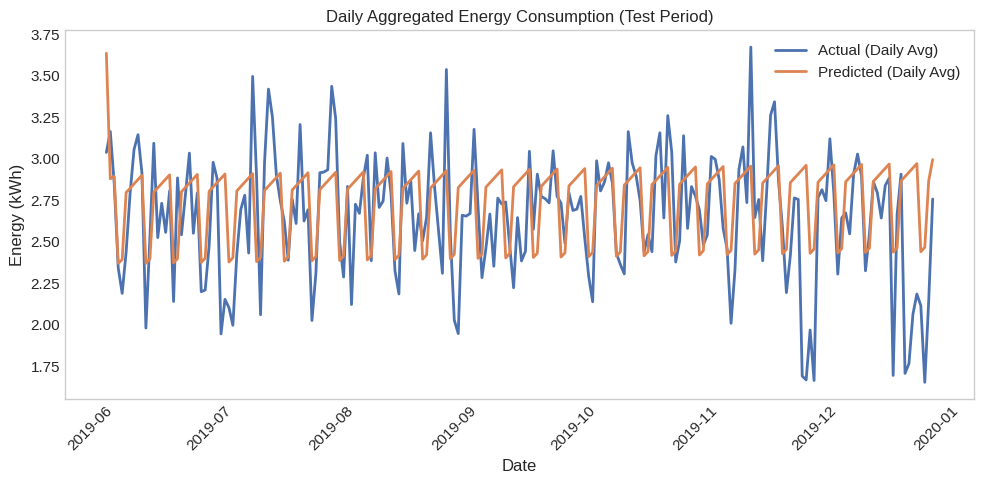

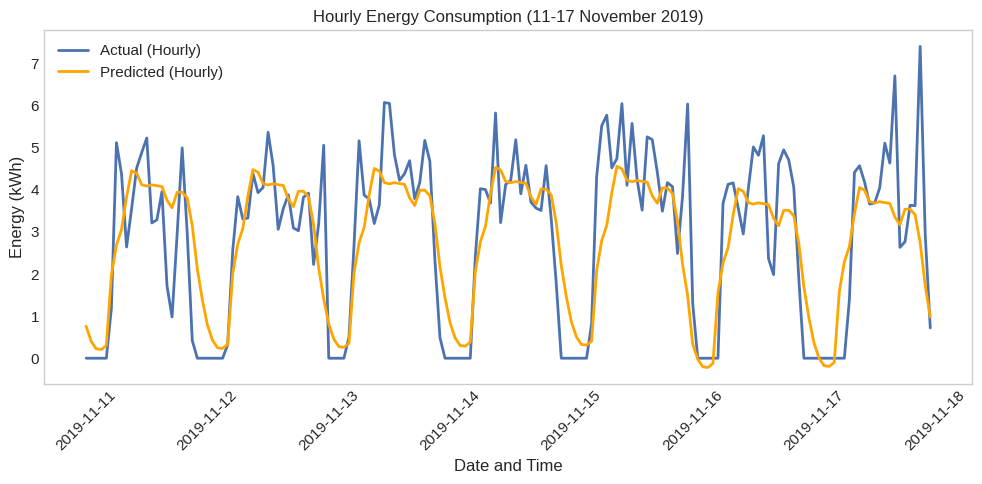

In [ ]:
# Merge data
test_data['Prediction'] = test_pred

# Aggregration of data
daily_actual = test_data.resample('D')['Energy (kWh)'].mean()
daily_predicted = test_data.resample('D')['Prediction'].mean()

# Plot of the whole prediction, but with daily average
plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_actual, label='Actual (Daily Avg)', linewidth=2)
sns.lineplot(data=daily_predicted, label='Predicted (Daily Avg)', linewidth=2)
plt.title("Daily Aggregated Energy Consumption (Test Period)")
plt.ylabel("Energy (kWh)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot of 1 week
nov_range = test_data.loc['2019-11-11':'2019-11-17']

plt.figure(figsize=(10, 5))
sns.lineplot(x=nov_range.index, y=nov_range['Energy (kWh)'], label='Actual (Hourly)', linewidth=2)
sns.lineplot(x=nov_range.index, y=nov_range['Prediction'], label='Predicted (Hourly)', color='orange', linewidth=2)
plt.title("Hourly Energy Consumption (11-17 November 2019)")
plt.ylabel("Energy (kWh)")
plt.xlabel("Date and Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Advanced Models

In [ ]:
df_prediction

Energy (kWh)  Hour  Day_of_Week  Is_Weekend
Time                                                            
2018-02-01 05:00:00      2.211917     5            3           0
2018-02-01 06:00:00      4.342016     6            3           0
2018-02-01 07:00:00      3.916695     7            3           0
2018-02-01 08:00:00      3.438598     8            3           0
2018-02-01 09:00:00      4.636268     9            3           0
...                           ...   ...          ...         ...
2019-12-31 17:00:00      3.138821    17            1           0
2019-12-31 18:00:00      2.687015    18            1           0
2019-12-31 19:00:00      3.209163    19            1           0
2019-12-31 20:00:00      3.966165    20            1           0
2019-12-31 21:00:00      1.152945    21            1           0

[16769 rows x 4 columns]

In [ ]:
# Split data into training and testing sets
train_size = int(0.7 * len(df_prediction))  # 70% for training
train_data = df_prediction.iloc[:train_size]
test_data = df_prediction.iloc[train_size:]

# Initialize the models

# Random Forest Regressor
model1 = RandomForestRegressor()
# Gradietn Boosting Regressor
model2 = GradientBoostingRegressor()
# XGBRegressor
model3 = XGBRegressor()

# Extract features from 'Time' in train_data
train_data_reset = train_data.reset_index()  # Reset index to include 'Time' as a column
train_data_reset['Year'] = train_data_reset['Time'].dt.year
train_data_reset['Month'] = train_data_reset['Time'].dt.month
train_data_reset['Day'] = train_data_reset['Time'].dt.day
train_data_reset['Hour_of_Day'] = train_data_reset['Time'].dt.hour

# Extract features from 'Time' in test_data
test_data_reset = test_data.reset_index()
test_data_reset['Year'] = test_data_reset['Time'].dt.year
test_data_reset['Month'] = test_data_reset['Time'].dt.month
test_data_reset['Day'] = test_data_reset['Time'].dt.day
test_data_reset['Hour_of_Day'] = test_data_reset['Time'].dt.hour

# Train the model
features = ['Year', 'Month', 'Day', 'Hour_of_Day', 'Day_of_Week', 'Is_Weekend']
target = 'Energy (kWh)'

model1.fit(train_data_reset[features], train_data_reset[target])
model2.fit(train_data_reset[features], train_data_reset[target])
model3.fit(train_data_reset[features], train_data_reset[target])


# Predict on the test set
y_pred1 = model1.predict(test_data_reset[features])
y_pred2 = model2.predict(test_data_reset[features])
y_pred3 = model3.predict(test_data_reset[features])


# Evaluate the model
r21 = r2_score(test_data_reset[target], y_pred1)
mae1 = mean_absolute_error(test_data_reset[target], y_pred1)
mape1 = mean_absolute_percentage_error(test_data_reset[target], y_pred1)
r22 = r2_score(test_data_reset[target], y_pred2)
mae2 = mean_absolute_error(test_data_reset[target], y_pred2)
mape2 = mean_absolute_percentage_error(test_data_reset[target], y_pred2)
r23 = r2_score(test_data_reset[target], y_pred3)
mae3 = mean_absolute_error(test_data_reset[target], y_pred3)
mape3 = mean_absolute_percentage_error(test_data_reset[target], y_pred3)

# Print results
print("Random Forest Regressor:")
print(f"R2 score: {r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}")

print("\n\n")
print("Gradient Boosting Regressor:")
print(f"R2 score: {r22:.2f}")
print(f"Mean Absolute Error: {mae2:.2f}")
print(f"Mean Absolute Percentage Error: {mape2:.2f}")

print("\n\n")
print("XGBoost Regressor:")
print(f"R2 score: {r23:.2f}")
print(f"Mean Absolute Error: {mae3:.2f}")
print(f"Mean Absolute Percentage Error: {mape3:.2f}")

Random Forest Regressor:
R2 score: 0.63
Mean Absolute Error: 0.85
Mean Absolute Percentage Error: 75.55



Gradient Boosting Regressor:
R2 score: 0.66
Mean Absolute Error: 0.79
Mean Absolute Percentage Error: 559284826164077.88



XGBoost Regressor:
R2 score: 0.61
Mean Absolute Error: 0.84
Mean Absolute Percentage Error: 623974745391967.25


# **Exploratory Component: Hoarding behaviour**

## Feature preprocessing

To understand hoarding behavior at EV charging stations, we define hoarding as a vehicle occupying a station for significantly longer than necessary for charging. This occurs when a vehicle remains plugged in after completing its charge, blocking others and reducing station efficiency. Hoarding decreases throughput and increases wait times, particularly during peak demand.

We define **hoarding as Idle Time (vehicle connected but not charging) exceeding a set threshold**, such as 50% of the total session.

In [ ]:
data=new_df
data = data.dropna(subset=['Transaction Date (Pacific Time)'])


In [ ]:
# Idle Time
data['Idle Time (hh:mm:ss)'] = pd.to_timedelta(data['Total Duration (hh:mm:ss)']) - pd.to_timedelta(data['Charging Time (hh:mm:ss)'])
data['Idle Time (hours)'] = data['Idle Time (hh:mm:ss)'].dt.total_seconds() / 3600
data['Hoarding Indicator'] = data['Idle Time (hours)'] / (pd.to_timedelta(data['Total Duration (hh:mm:ss)']).dt.total_seconds() / 3600) > 0.5

# Data by each station
station_agg = data.groupby('Station Name').agg({
    'Hoarding Indicator': 'mean',
    'Idle Time (hours)': 'mean',
    'Energy (kWh)': 'sum',
    'Fee': 'sum',
    'Latitude': 'first',
    'Longitude': 'first'
}).reset_index()

station_agg.rename(columns={
    'Hoarding Indicator': 'Hoarding Rate',
    'Idle Time (hours)': 'Avg Idle Time (hours)',
    'Energy (kWh)': 'Total Energy (kWh)',
    'Fee': 'Total Fee ($)'
}, inplace=True)

print(station_agg.head())


<ipython-input-51-1d7675e6c5b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Idle Time (hh:mm:ss)'] = pd.to_timedelta(data['Total Duration (hh:mm:ss)']) - pd.to_timedelta(data['Charging Time (hh:mm:ss)'])
<ipython-input-51-1d7675e6c5b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Idle Time (hours)'] = data['Idle Time (hh:mm:ss)'].dt.total_seconds() / 3600
<ipython-input-51-1d7675e6c5b1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

               Station Name  Hoarding Rate  Avg Idle Time (hours)  \
0  PALO ALTO CA / BRYANT #1       0.045812               0.257308   
1  PALO ALTO CA / BRYANT #2       0.059163               0.263056   
2  PALO ALTO CA / BRYANT #3       0.050500               0.250894   
3  PALO ALTO CA / BRYANT #4       0.025746               0.189022   
4  PALO ALTO CA / BRYANT #5       0.027098               0.167861   

   Total Energy (kWh)  Total Fee ($)   Latitude   Longitude  
0        32486.622226        3045.53  37.446613 -122.162308  
1        34466.604574        3381.82  37.446510 -122.162140  
2        29318.036617        2869.35  37.446583 -122.162109  
3        22790.828000        5171.00  37.446785 -122.162369  
4        31833.305000        7305.65  37.446690 -122.162231  


<ipython-input-52-7b19bb11579f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hoarding Rate', y='Station Name', data=top_hoarding, palette='viridis')


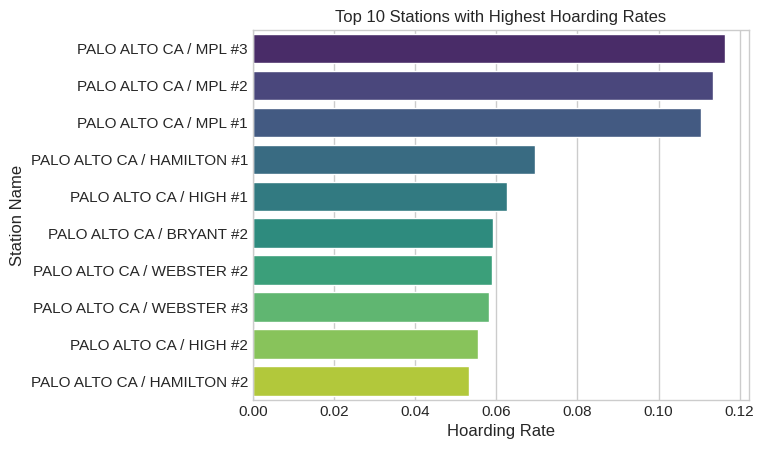

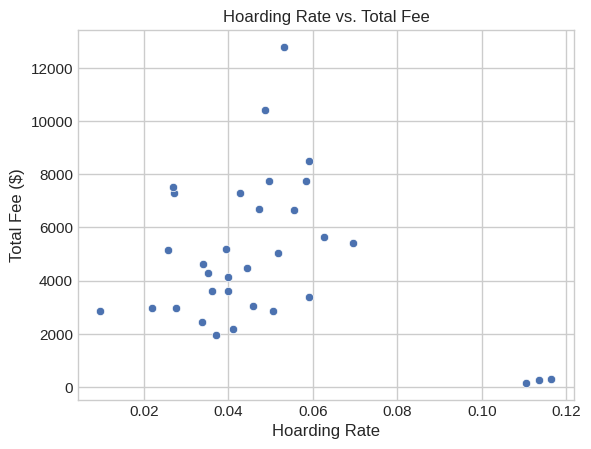

In [ ]:
top_hoarding = station_agg.sort_values('Hoarding Rate', ascending=False).head(10)
sns.barplot(x='Hoarding Rate', y='Station Name', data=top_hoarding, palette='viridis')
plt.title('Top 10 Stations with Highest Hoarding Rates')
plt.xlabel('Hoarding Rate')
plt.ylabel('Station Name')
plt.show()

sns.scatterplot(x='Hoarding Rate', y='Total Fee ($)', data=station_agg)
plt.title('Hoarding Rate vs. Total Fee')
plt.xlabel('Hoarding Rate')
plt.ylabel('Total Fee ($)')
plt.show()

A scatter plot of hoarding rate per station versus average fee time shows that stations with the **highest hoarding rates often have very low fees**. This indicates that the current fee structure may fail to discourage extended usage, allowing users to occupy stations longer without significant costs. Low fees likely contribute to hoarding, where vehicles remain parked after charging. Adjusting the pricing model, such as using time-based or tiered fees, could help reduce hoarding and improve station efficiency

## Hoarding: map visualisation

The map shows that the top 10 stations with the highest hoarding rates (red dots) are clustered near busy locations like the library and courthouse. These areas attract high foot traffic, contributing to prolonged idle times after charging sessions.

At the library, users may park for extended periods especially during peak hours. Similarly, the courthouse draws people for lengthy activities leading to extended vehicle idle times.

Implementing strategies like session time limits or idle-time notifications could help manage these high-hoarding locations effectively.

In [ ]:
#aggregating the stations in order to understand the biggest idle times
station_agg['Common Station Name'] = station_agg['Station Name'].str.split("PALO ALTO CA /").str[-1].str.strip()

aggregated_stations = station_agg.groupby('Common Station Name').agg({
    'Hoarding Rate': 'mean',
    'Avg Idle Time (hours)': 'mean',
    'Total Fee ($)': 'sum',
    'Total Energy (kWh)': 'sum',
    'Latitude': 'mean',
    'Longitude': 'mean'
}).reset_index()


top_10_aggregated = aggregated_stations.sort_values('Hoarding Rate', ascending=False).head(10)

map = folium.Map(location=[aggregated_stations['Latitude'].mean(), aggregated_stations['Longitude'].mean()], zoom_start=12)
for _, row in aggregated_stations.iterrows():
    if row['Common Station Name'] in top_10_aggregated['Common Station Name'].values:
        color = 'red'
        radius = row['Hoarding Rate'] * 30  # Make red dots larger for top 10
    else:

        color = 'blue'
        radius = row['Hoarding Rate'] * 20  # Smaller dots for other stations

    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=radius,
        popup=(
            f"Station: {row['Common Station Name']}\n"
            f"Hoarding Rate: {row['Hoarding Rate']:.2f}\n"
            f"Total Energy: {row['Total Energy (kWh)']:.2f} kWh\n"
            f"Total Fee: ${row['Total Fee ($)']:.2f}"
        ),
        color=color,
        fill=True,
        fill_opacity=0.8
    ).add_to(map)


map


## Hoarding visualisation and analysis


In [ ]:
#changing the datatime series into extra features for visualisation and used later for training the model
def time_to_hours(time_str):
    if isinstance(time_str, str):
        hours, minutes, seconds = time_str.split(':')
        hours = int(hours)
        minutes = int(minutes)
        seconds = int(seconds)
        return hours + (minutes / 60) + (seconds / 3600)
    return 0.0


data['Charging Time (hours)'] = data['Charging Time (hh:mm:ss)'].apply(time_to_hours)

data['Transaction Date (Pacific Time)'] = pd.to_datetime(data['Transaction Date (Pacific Time)'])

data['Day of Week'] = data['Transaction Date (Pacific Time)'].dt.dayofweek

data['Year'] = data['Transaction Date (Pacific Time)'].dt.year

data['Hour of Day'] = data['Transaction Date (Pacific Time)'].dt.hour

data['Is Weekend'] = data['Day of Week'].apply(lambda x: 1 if x >= 5 else 0)

data['Month'] = data['Transaction Date (Pacific Time)'].dt.month

<ipython-input-54-c18dc70c25c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Charging Time (hours)'] = data['Charging Time (hh:mm:ss)'].apply(time_to_hours)
<ipython-input-54-c18dc70c25c0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Transaction Date (Pacific Time)'] = pd.to_datetime(data['Transaction Date (Pacific Time)'])
<ipython-input-54-c18dc70c25c0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

<ipython-input-55-bcfdc31abeaf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Day of Week Name'] = data['Day of Week'].apply(lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][x])
<ipython-input-55-bcfdc31abeaf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Month Name'] = data['Month'].apply(lambda x: ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'][x-1])
<ipython-input-55-bcfdc3

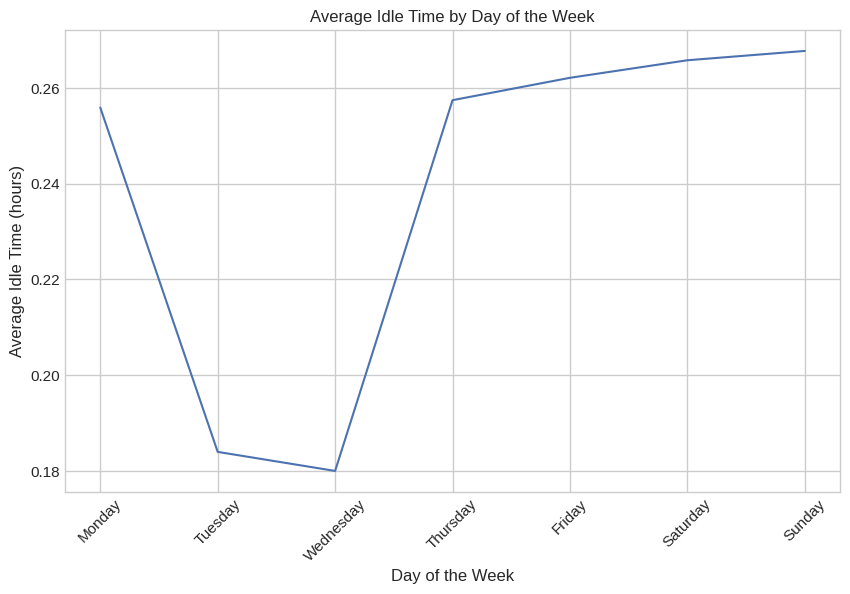

<ipython-input-55-bcfdc31abeaf>:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Month Name', y='Idle Time (hours)', data=data, estimator='mean', markers=True, sort=False, ci=None)


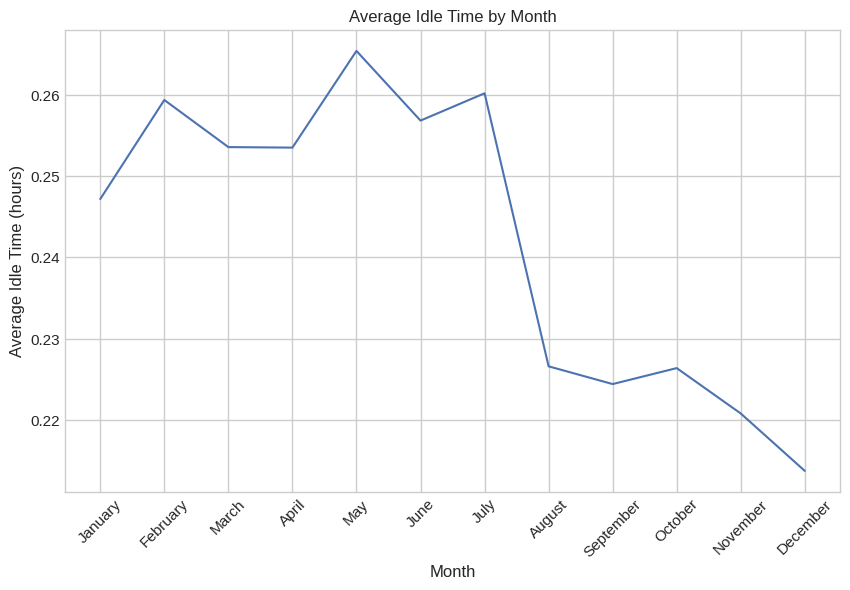

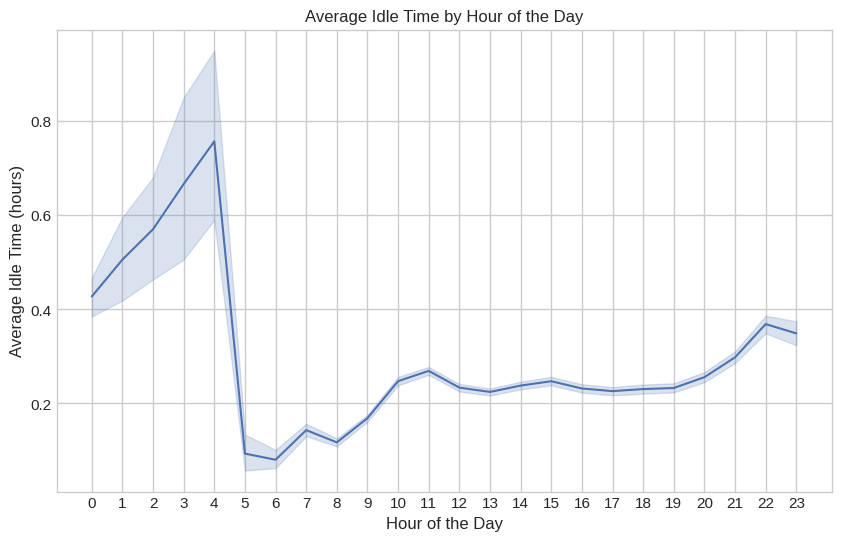

<ipython-input-55-bcfdc31abeaf>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Year', y='Idle Time (hours)', data=data, estimator='mean', markers=True, ci=None)


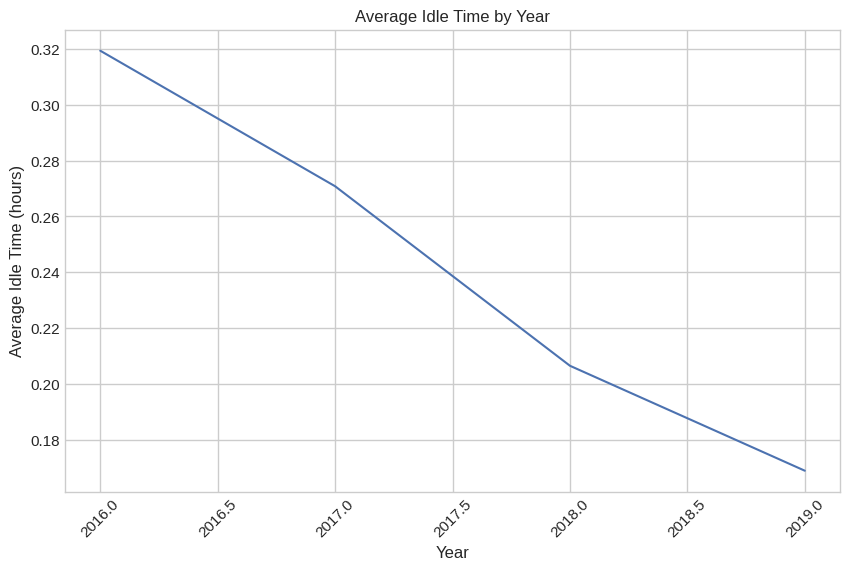

In [ ]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


data['Day of Week Name'] = data['Day of Week'].apply(lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][x])
data['Month Name'] = data['Month'].apply(lambda x: ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'][x-1])


plt.figure(figsize=(10, 6))
sns.lineplot(x='Day of Week Name', y='Idle Time (hours)', data=data, estimator='mean', markers=True, sort=False, ci=None)
plt.title('Average Idle Time by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Idle Time (hours)')
plt.xticks(ticks=range(7), labels=day_order, rotation=45)
plt.show()


plt.figure(figsize=(10, 6))
sns.lineplot(x='Month Name', y='Idle Time (hours)', data=data, estimator='mean', markers=True, sort=False, ci=None)
plt.title('Average Idle Time by Month')
plt.xlabel('Month')
plt.ylabel('Average Idle Time (hours)')
plt.xticks(ticks=range(12), labels=month_order, rotation=45)
plt.show()


plt.figure(figsize=(10, 6))
sns.lineplot(x='Hour of Day', y='Idle Time (hours)', data=data, estimator='mean', markers=True)
plt.title('Average Idle Time by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Idle Time (hours)')
plt.xticks(range(24))
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Idle Time (hours)', data=data, estimator='mean', markers=True, ci=None)
plt.title('Average Idle Time by Year')
plt.xlabel('Year')
plt.ylabel('Average Idle Time (hours)')
plt.xticks(rotation=45)  # Rotate the years for better readability if needed
plt.show()

Based on the visualizations, here are the key observations:

**Idle Time by Day of the Week**: Tuesdays and Wednesdays have the lowest idle times, with more consistent levels across other days, suggesting a midweek dip linked to user behavior.

**Idle Time by Month**: Idle times increase steadily from January to July, then drop sharply, reflecting possible seasonal patterns or changes in charging habits.

**Idle Time by Hour**: Idle time spikes between midnight and 5 AM, likely due to vehicles being left plugged in overnight, and decreases sharply after 8 AM as users move their vehicles during the day.

**Idle Time by Year**: Idle times steadily decreased from 2016 to 2019, indicating improvements in user behavior or charging station management.

The hour of the day has the most significant impact, with nighttime showing the longest periods. The decline in idle times over the years highlights positive trends in charging efficiency. Midweek and seasonal patterns are subtler but still provide insights into user habits.

## Final model: hoarding prediction

A Random Forest Classifier predicts the Hoarding Index. Categorical features such as clusters, day of the week and month are mapped into discrete numerical values and standardized to ensure uniform scaling across features. This preprocessing step prevents features with larger ranges from dominating the model and improves overall performance. Nested cross-validation ensures robust evaluation, with GridSearchCV optimizing hyperparameters. The final model, trained with optimal settings, is assessed using different metrics.

In [ ]:
data_copy=data.copy()

In [ ]:
data['Total Duration (hours)'] = data['Total Duration (hh:mm:ss)'].apply(time_to_hours)
data['Charging Time (hours)'] = data['Charging Time (hh:mm:ss)'].apply(time_to_hours)
y=data['Hoarding Indicator']
features = ['Charging Time (hours)', 'Year', 'Day of Week', 'Hour of Day','Is Weekend',  'Month', 'Fee', 'Latitude', 'Longitude', 'Cluster']
#scaling the data to remove the bias
scaler = StandardScaler()

data= scaler.fit_transform(data[features])
df = pd.DataFrame(data, columns=features)
df.head()



<ipython-input-57-4985b8324c7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Total Duration (hours)'] = data['Total Duration (hh:mm:ss)'].apply(time_to_hours)
<ipython-input-57-4985b8324c7b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Charging Time (hours)'] = data['Charging Time (hh:mm:ss)'].apply(time_to_hours)


Charging Time (hours)      Year  Day of Week  Hour of Day  Is Weekend  \
0              -0.246392 -1.315055     0.593934    -0.896258   -0.556533   
1              -0.855016 -1.315055     0.593934    -1.131679   -0.556533   
2               0.144378 -1.315055     0.593934    -0.660836   -0.556533   
3               1.572084 -1.315055     0.593934    -0.425414   -0.556533   
4              -0.638870 -1.315055     0.593934    -0.660836   -0.556533   

      Month       Fee  Latitude  Longitude   Cluster  
0 -1.607284 -0.843223  0.770426  -0.765539  0.840976  
1 -1.607284 -0.843223  0.780801  -0.776509  0.840976  
2 -1.607284 -0.843223 -1.684633   2.413377 -1.189095  
3 -1.607284 -0.843223  0.949126  -0.512965 -1.189095  
4 -1.607284 -0.843223  0.780801  -0.776509  0.840976

Outer Cross-Validation Accuracy scores: [0.96373228 0.96516995 0.96376117 0.96460044 0.96346142]
Mean Outer Cross-Validation Accuracy: 0.96414505286087
Accuracy on full dataset: 0.9773695979281942
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    158872
        True       1.00      0.52      0.69      7939

    accuracy                           0.98    166811
   macro avg       0.99      0.76      0.84    166811
weighted avg       0.98      0.98      0.97    166811



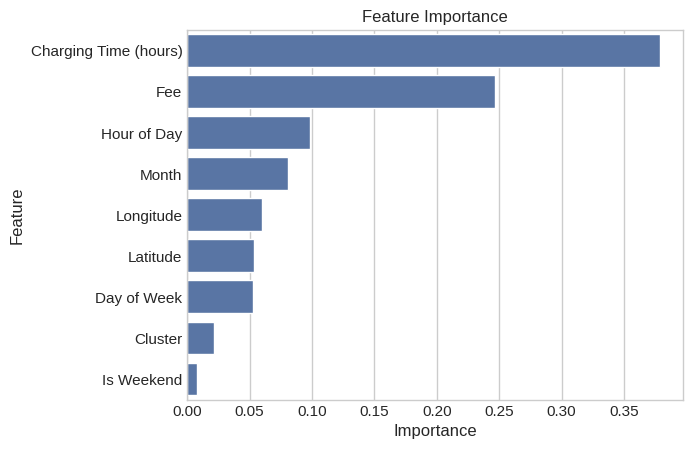

In [ ]:
features = ['Charging Time (hours)', 'Day of Week', 'Hour of Day', 'Is Weekend', 'Month', 'Fee', 'Latitude', 'Longitude', 'Cluster']
X = df[features]

# 2 fold cross validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
model = RandomForestClassifier(random_state=42, n_jobs=-1)


param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)

outer_cv_scores = cross_val_score(grid_search, X, y, cv=outer_cv, scoring='accuracy')

print(f'Outer Cross-Validation Accuracy scores: {outer_cv_scores}')
print(f'Mean Outer Cross-Validation Accuracy: {outer_cv_scores.mean()}')

best_model = grid_search.fit(X, y).best_estimator_


y_pred = best_model.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy on full dataset: {accuracy}')
print(classification_report(y, y_pred))

feature_importances = pd.DataFrame({'Feature': features, 'Importance': best_model.feature_importances_})
feature_importances.sort_values('Importance', ascending=False, inplace=True)

sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()



Investigating lowering the hoarding threshold to 25% reduced accuracy to 88%, which is expected since hoarding patterns are harder to detect. This drop reflects the model’s effort to identify more nuanced hoarding behaviors.

In [ ]:
data=data_copy.copy()

In [ ]:
data['Hoarding Indicator'] = data['Idle Time (hours)'] / (pd.to_timedelta(data['Total Duration (hh:mm:ss)']).dt.total_seconds() / 3600) > 0.25
data['Total Duration (hours)'] = data['Total Duration (hh:mm:ss)'].apply(time_to_hours)
data['Charging Time (hours)'] = data['Charging Time (hh:mm:ss)'].apply(time_to_hours)
#data['Loss'] = (data['Idle Time (hours)'] / data['Total Duration (hours)']) * data['Fee']
#data = data.dropna(subset=['Loss'])
y=data['Hoarding Indicator']
features = ['Charging Time (hours)', 'Year', 'Day of Week', 'Hour of Day','Is Weekend',  'Month', 'Fee', 'Latitude', 'Longitude', 'Cluster']

scaler = StandardScaler()

data= scaler.fit_transform(data[features])
df = pd.DataFrame(data, columns=features)
X = df[features]

Outer Cross-Validation Accuracy scores: [0.88367353 0.88259097 0.88405971 0.88438943 0.88235118]
Mean Outer Cross-Validation Accuracy: 0.8834129628107993
Accuracy on full dataset: 0.9259641150763439
              precision    recall  f1-score   support

       False       0.92      1.00      0.96    142626
        True       1.00      0.49      0.66     24185

    accuracy                           0.93    166811
   macro avg       0.96      0.75      0.81    166811
weighted avg       0.93      0.93      0.91    166811



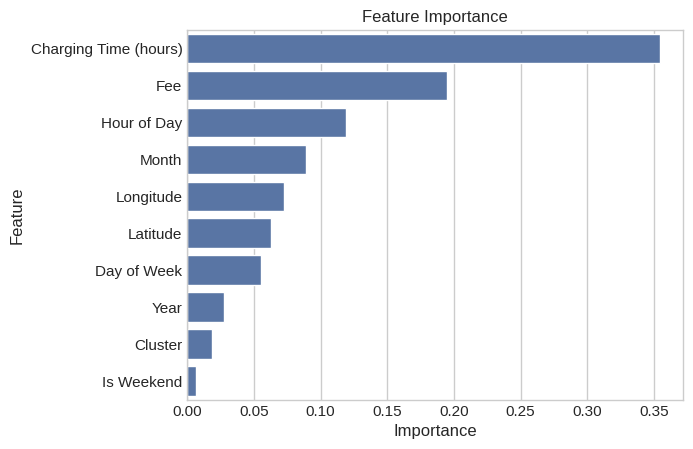

In [ ]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
model = RandomForestClassifier(random_state=42, n_jobs=-1)
#grid for best performance
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
}


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)

outer_cv_scores = cross_val_score(grid_search, X, y, cv=outer_cv, scoring='accuracy')

print(f'Outer Cross-Validation Accuracy scores: {outer_cv_scores}')
print(f'Mean Outer Cross-Validation Accuracy: {outer_cv_scores.mean()}')

best_model = grid_search.fit(X, y).best_estimator_
y_pred = best_model.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy on full dataset: {accuracy}')


print(classification_report(y, y_pred))


feature_importances = pd.DataFrame({'Feature': features, 'Importance': best_model.feature_importances_})
feature_importances.sort_values('Importance', ascending=False, inplace=True)


sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()


# **Conlusions**

We found it particularly fascinating to analyze this dataset in depth, especially to understand the significant increase in EV usage observed between 2015 and 2016. Through meticulous analysis, we revealed fascinating trends: the increasing popularity of some plug types over time, while others fade into obsolescence. Surprisingly, however, this surge in activity was not due to an explosion in the number of charging stations, but was driven by something else.  

Curious to find out the cause, we dug deeper. Could it be the change in energy prices? No, there is no record of such an occurrence. So we thought it might be the electric vehicle market itself. And there it was: the shift! The launch of Tesla's Model X in 2015 had electrified the scene, triggering unprecedented demand.  

**When data are explored with curiosity and passion, they tell so many stories!**



# **Appendix**

## **A.1 Individual contributions**
All the members have contributed equally to the development of the code and writing of the project. With focus on:

*   Barbara: report writing, exploratory component
*   Ignacio: report writing, data cleaning, data visualizatoin and clustering
*   Giulia: report writing, time series prediction model
*   Gianmarco: report writing, data cleaning and data visualization and clustering



## **A.2 Augmented Dickey-Fuller (ADF) Test**

This statistical test is the most common method for testing stationarity,

Null Hypothesis (H₀): The series has a unit root (i.e., it is not stationary).
Alternative Hypothesis (H₁): The series is stationary.

In [ ]:
# Perform the ADF test
result = adfuller(df_advanced["Energy (kWh)"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"    {key}: {value:.3f}")

# Interpretation
if result[1] <= 0.05:
    print("The series is stationary (reject H₀).")
else:
    print("The series is not stationary (fail to reject H₀).")




ADF Statistic: -18.21103508201244
p-value: 2.3926878878347675e-30
Critical Values:
    1%: -3.431
    5%: -2.862
    10%: -2.567
The series is stationary (reject H₀).


## **A.3 Weekday vs Weekend differences in TS**
- Calulation of percentage decrease of average consumption between weekend and weekdays.

- Plot of the time serie divided between weekend (green line) and weekday (blue line).

In [ ]:
weekday_values = [2.45, 2.58, 2.74, 2.64, 2.77]
avg_weekday = sum(weekday_values) / len(weekday_values)
weekend_values = [2.23, 1.97]
avg_weekend = sum(weekend_values) / len(weekend_values)

# percentage decrease
percentage_decrease = ((avg_weekday - avg_weekend) / avg_weekday) * 100
avg_weekday, avg_weekend, percentage_decrease


(2.636, 2.1, 20.333839150227618)

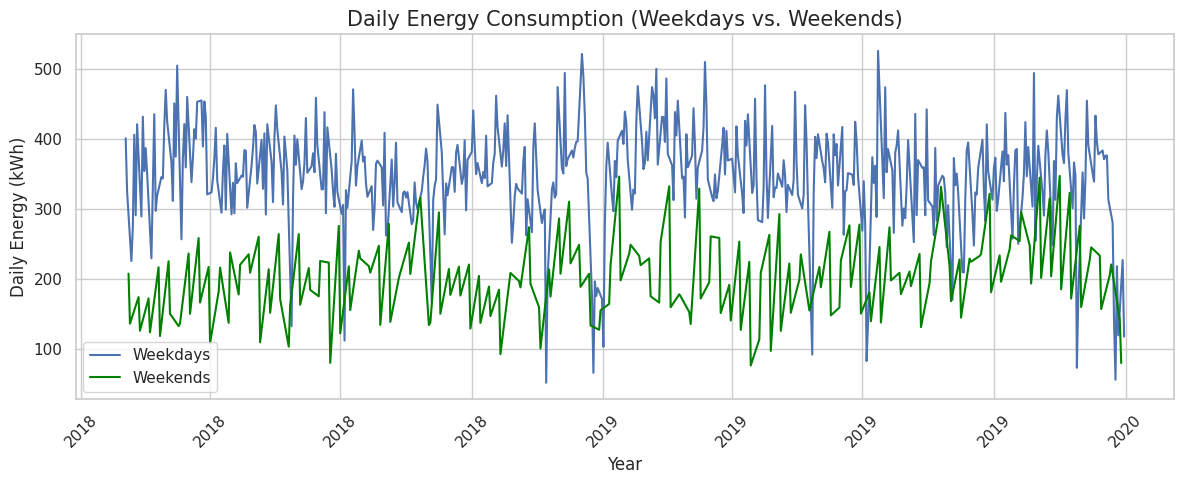

In [ ]:
dfTS = dfTS1.copy()

# Aggregate energy values per day by summing
daily_energy = dfTS.groupby(dfTS["Time"].dt.date)["Energy (kWh)"].sum().reset_index()
daily_energy["Time"] = pd.to_datetime(daily_energy["Time"])

# Identify weekends (Saturday, Sunday) for grouping
daily_energy["Weekend"] = daily_energy["Time"].dt.dayofweek >= 5  # 5 = Saturday, 6 = Sunday

# Split data into weekdays and weekends
weekdays_data = daily_energy[~daily_energy["Weekend"]]
weekends_data = daily_energy[daily_energy["Weekend"]]

# Create the plot
plt.figure(figsize=(12, 5))
plt.plot(weekdays_data["Time"], weekdays_data["Energy (kWh)"],
         linewidth=1.5, linestyle='-', label="Weekdays")
plt.plot(weekends_data["Time"], weekends_data["Energy (kWh)"],
         linewidth=1.5, linestyle='-', color='green', label="Weekends")
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().margins(x=0.05)
plt.title("Daily Energy Consumption (Weekdays vs. Weekends)", fontsize=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Daily Energy (kWh)", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
